#### Miniproject 2: Melody generation

## Introduction

### Description

To develop a model employing ANN on real-world data requires going through several major steps, each of which with important design choices that directly impact the end results. In this project, we guide you through these choices starting from a large database of [Irish folk melodies](https://github.com/IraKorshunova/folk-rnn/tree/master/data) to your own model of symbolic music composition. 


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. Please ensure that your notebook is fully executed before handing it in. 

## Functions and imports

For your convenience we import some libraries and provide some functions below. Some libraries (`midi` and `music21==5.1.0`) should be added. If you work with the docker image, pull it `docker pull zifeo/artificial-neural-networks:cpu` before to get the latest version where these libraries are added and stop/relaunch the container (as stated in the instructions https://github.com/zifeo/artificial-neural-networks). If you work locally, be sure to import them. If you do not find the midi library for python3, install it with `python setup.py install` inside the `python3-midi` folder after cloning https://github.com/louisabraham/python3-midi.git.

Finally, fill in your sciper number(s) for the random seed and simply run the following cell.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys

sciper = {'student_1': 'Federico Betti', 
          'student_2': 'Gauthier Mueller'}
seed = sciper['student_1']+sciper['student_2']
hash_equal = hash(seed)
np.random.seed(hash_equal % 2**32)
%matplotlib inline


plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 8, 4

import keras
from keras.models import Model, load_model, model_from_json
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN
from keras.optimizers import Adam
from keras.utils import np_utils, plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras import backend as K

import midi
import music21

# Our imports
import collections

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plotMelody(P, T, dictionaries, PrP=None, PrT=None, H=None):
    """
    P: The pitch array (integer representation) or matrix (one-hot encoding)
    T: The duration array (integer representation) or matrix (one-hot encoding)
    dictionaries: The dictionaries relating integer to a pitch or duration
    PrP: (Optional) If provided with PrT, plot the transition probabilities
    PrT: (Optional) If provided with PrP, plot the transition probabilities
    H: (Optional) Add a plot with the hidden state dynamic sorted by frequency
    """
    P = np.asarray(P)
    T = np.asarray(T)
    if len(P.shape) == 1:#if array
        P = np_utils.to_categorical(P, len(dictionaries['P']))
    if len(T.shape) == 1:#if array
        T = np_utils.to_categorical(T, len(dictionaries['T']))
    
    xlim = [-1,np.where(P==1)[0][-1]+1]
    
    activeidxes = np.where(np.sum(P, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrP is not None:
        targets = np.where(P[:,activeidxes]==1)
        plt.imshow(PrP[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.') 
    else:
        plt.imshow(P[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["P"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$P[n]$")
    plt.xlim(xlim)
    plt.show()
    
    activeidxes = np.where(np.sum(T, axis=0)>1.)[0]
    plt.figure(figsize=(8,4))
    if PrT is not None:
        targets = np.where(T[:,activeidxes]==1)
        plt.imshow(PrT[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
        plt.scatter(targets[0]-1,targets[1], color='red',s=10, marker='.')
    else:
        plt.imshow(T[:,activeidxes].T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
    plt.ylim([-0.5,len(activeidxes)-0.5])
    plt.yticks(range(len(activeidxes)),[dictionaries["T"][i] for i in activeidxes])
    plt.tight_layout()
    plt.xlabel("$n$")
    plt.ylabel("$T[n]$")
    plt.xlim(xlim)
    plt.show()
    
    
    if H is not None:
        diff = np.mean([[abs(j-i) for i,j in zip(H[:xlim[1]-1,k], H[1:xlim[1],k])] for k in range(H.shape[1])], axis=1)
        sortidx = np.argsort(-diff)
        H = H[:,sortidx]
        plt.figure(figsize=(8,4))
        plt.imshow(H.T, origin='lower', aspect='auto', interpolation='nearest', cmap=plt.cm.seismic, vmin=-1, vmax=1)
        plt.xlim([-1,np.where(T==1)[0][-1]+1])
        plt.tight_layout()
        plt.xlabel("$n$")
        plt.ylabel("$H[n]$")
        plt.show()


def plotLearningCurves(History):
    
    log = History.history
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_loss'], '--', c=c[0], label='Pitch train loss')
    plt.plot(log['val_YP_loss'], c=c[0], label='Pitch val loss')
    
    plt.plot(log['YT_loss'], '--', c=c[1], label='Dur train loss')
    plt.plot(log['val_YT_loss'], c=c[1], label='Dur val loss')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.plot(log['YP_acc'], '--', c=c[0], label='Pitch train acc')
    plt.plot(log['val_YP_acc'], c=c[0], label='Pitch val acc')
    
    plt.plot(log['YT_acc'], '--', c=c[1], label='Dur train acc')
    plt.plot(log['val_YT_acc'], c=c[1], label='Dur val acc')
    plt.legend(loc='best')
    
# plot only validation loss and validation accuracy 
def plotLearningCurvesMoreHistories(histories, names=None):
    if not names:
        names = ['']*len(histories)
    # plotting validation losses
    plt.figure(figsize=(8,4))
    i = 0
    for hist, name in zip(histories, names):
        history = hist.history
        plt.plot(history['val_YP_loss'], c=c[i], label=name + ' Pitch train loss')
        plt.plot(history['val_YT_loss'],'--', c=c[i], label=name + ' Durations train loss')
        i += 1
        
    plt.legend(loc='best')
    
    # plotting validation accuracies
    plt.figure(figsize=(8,4))
    i = 0
    for hist, name in zip(histories, names):
        history = hist.history
        plt.plot(history['val_YP_acc'], c=c[i], label=name + ' Pitch train acc')
        plt.plot(history['val_YT_acc'], '--', c=c[i], label=name + ' Durations train acc')
        i += 1
        
    plt.legend(loc='best')

def sample(preds, temperature=1.):
    """Helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def writeMIDI(xP, xT, dictionaries, label):

    # Instantiate a MIDI Pattern (contains a list of tracks)
    pattern = midi.Pattern(format = 0, resolution=480)
    # Instantiate a MIDI Track (contains a list of MIDI events)
    track = midi.Track()
    # Append the track to the pattern
    pattern.append(track)
    Events = []
    
    pseq = [dictionaries['P'][p] for p in xP]
    tseq = [dictionaries['T'][t] for t in xT]
    for t, p in zip(tseq, pseq):
        e = midi.NoteOnEvent(tick=0, velocity=90, pitch=p)
        track.append(e)
        e = midi.NoteOffEvent(tick=t, velocity=0, pitch=p)
        track.append(e)
        
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    # Save the pattern to disk
    midi.write_midifile(label, pattern)

## Exercise 1 : Data processing
### Description

For a real world application of ANNs, the original data should be translated into a representation understandable by an ANN. This step is often neglected but is of outmost importance. In order for you to better understand how ANN are applied to real world problems, the first step of this miniproject will guide you through a possible representation. 

Note that in general, your representation should be normalized in order to obtain homogeneous data from which a structure can be extracted by your ANN model. Importantly, all processing steps toward your representation should not (or minimally) distort your original data.

To represent MIDI files, we provide you with a Python MIDI library. You should then

0. Download the MIDI tar file from [this link](https://github.com/IraKorshunova/folk-rnn/tree/master/data) and put it in a folder named "chorpus" at the same level of this notebook.
1. Parse the chorpus to extract the label of (a random subset of) the data (code is provided)
2. Read each MIDI file in the subset with the midi [library](https://github.com/louisabraham/python3-midi)
3. For each data sequence extract the sequence of MIDI notes defined by two dimensions ("P": the sequence of note pitches (integer between 0 and 127 representing a piano key), "T": the sequence of note durations.
4. Select two melodies and display them both as sequences of MIDI events and sequence of notes in two dimensions. Control that your representation is correct.

For step 3, you should learn how MIDI files are constructed. Below, we give a minimal explanation and some code for this particular project. For a more complete explanation, look for MIDI in your favorite search engine. Given this dataset, you can observe that it is monophonic (one note at a time) and there's a small delay (1 tick) inbetween each note. You could decide to ignore this delay or correct (recommanded) for it.

A MIDI files is composed of timed events of many kinds. For this project, we focus on the events related to notes being played or stopped. Those are MIDI events "Note Off" and "Note On". Each event is timed with respect with the previous one (dt). The duration of a note is therefore given by the cummulated dt inbetween the event associated to a note's onset and the event associated with the same note's offset.
        

### Minimal code to read MIDI files

In [3]:
def display(midi_file="chorpus/sessiontune0.mid"):
    #index 0 for first track only
    events = midi.read_midifile(midi_file)[0] 
    tick = 0
    print(midi_file)
    print("#"*40)
    print("tick \t pitch \t message \t velocity")
    print("#"*40+'\n')
    for n, event in enumerate(events):
        tick += event.tick
        if event.name in ['Note On', 'Note Off']:
            if n<13 or n>len(events)-10:
                print("%i \t %i \t %s \t %i"%(tick, event.data[0], event.name, event.data[1]))
            if n in range(20,23):
                print(". \t . \t . \t \t .")
    print("#"*40+'\n')

display()

datapath = "chorpus/"
dataset = {}
# np.random.seed(seed) already done in first lines

for filename in os.listdir(datapath):
    if filename.endswith("mid"):
        label = filename[:-4]
        #Down sample dataset
        if np.random.rand() < 0.1:
            dataset[label] = {"T":[], "P": []}
print("%i/%i melodies retained"%(len(list(dataset.keys())), len(os.listdir(datapath))))

chorpus/sessiontune0.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 67 	 Note On 	 105
240 	 67 	 Note Off 	 0
241 	 64 	 Note On 	 80
480 	 64 	 Note Off 	 0
481 	 64 	 Note On 	 80
720 	 64 	 Note Off 	 0
721 	 64 	 Note On 	 95
1200 	 64 	 Note Off 	 0
1201 	 62 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
33601 	 67 	 Note On 	 80
33840 	 67 	 Note Off 	 0
33841 	 69 	 Note On 	 95
34080 	 69 	 Note Off 	 0
34081 	 71 	 Note On 	 80
34320 	 71 	 Note Off 	 0
34321 	 72 	 Note On 	 80
34560 	 72 	 Note Off 	 0
########################################

4600/45854 melodies retained


### Solution

In [4]:
# event.data[0] = P, event.data[1] = velocity
def parseMIDI(midi_file):
    events = midi.read_midifile(midi_file)[0] #index 0 for first track only  
    T = []
    P = []
    tick = 0
    for n, event in enumerate(events):
        # try to correct one tick delay between two notes
        if event.name in ['Note On']:
            tick_on = tick
            P.append(event.data[0])
        elif event.name in ['Note Off']:
            tick += (event.tick + 1)
            T.append(tick - tick_on)
        
    return P, T

for label in list(dataset.keys()):
    Pseq, Tseq = parseMIDI(datapath+label+".mid")
    dataset[label]['T']= Tseq
    dataset[label]['P']= Pseq

for label in np.random.choice(list(dataset.keys()), 2):
    print(label)
    print("MIDI events")
    display(datapath+label+".mid")
    print("Note representation")
    print(dataset[label])
    print('/n')


sessiontune7514
MIDI events
chorpus/sessiontune7514.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 69 	 Note On 	 105
480 	 69 	 Note Off 	 0
481 	 62 	 Note On 	 80
720 	 62 	 Note Off 	 0
721 	 64 	 Note On 	 80
960 	 64 	 Note Off 	 0
961 	 65 	 Note On 	 95
1200 	 65 	 Note Off 	 0
1201 	 64 	 Note On 	 80
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
60241 	 67 	 Note On 	 80
60480 	 67 	 Note Off 	 0
60481 	 69 	 Note On 	 95
60720 	 69 	 Note Off 	 0
60721 	 62 	 Note On 	 80
60960 	 62 	 Note Off 	 0
60961 	 62 	 Note On 	 80
61440 	 62 	 Note Off 	 0
########################################

Note representation
{'P': [69, 62, 64, 65, 64, 65, 69, 67, 60, 64, 62, 60, 64, 67, 67, 70, 69, 62, 62, 64, 65, 67, 69, 71, 72, 71, 69, 67, 69, 74, 74, 76, 74, 62, 64, 65, 67, 69, 71, 72, 60, 64, 62, 60, 64, 67, 67, 69, 67, 65, 67, 69, 71, 72, 71, 69, 67, 69, 62, 62, 69, 62, 64, 65, 64, 65, 69, 67, 60, 64, 62, 6

## Exercise 2: Tokenzation and translation to integer
### Description

Now you should have a "dataset" dictionary where each entry corresponds to one melody example from a subset of the full dataset. In turn, every melody example is represented by a dictionary with two sequences: the "P" entry being the sequence of pitches and the "T" entry, the sequence of durations. Here, you will implement the first steps to translate this dataset in a language that can be read by your ANN models. To achieve that, we will later use the [one-hot encoding scheme](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/), which will associate each input (and output) unit of your network to a unique pitch or duration. In your network, these units will then be sequentially activated in the same order as their corresponding pitch/duration in your dataset. And at each note, the model will be trained to approximate the probability distributions of the upcoming pitch and duration.

1. Gather in a list of all possible pitches and durations in your dataset. These two lists will be your "dictionaries" translating a pitch/duration to a unique integer between 0 and the number of entries (-1) in the pitch/duration dictionary.
2. Translate the pitch/duration sequence of each melody to the integer representation.
3. Select randomly two melodies and display them in the note representation and translated to integer. Check that the translation is correct.

### Solution

In [5]:
def get_all_entries(dataset):
    pitches = set()
    durations = set()

    for label in list(dataset.keys()):
        for pitch in dataset[label]['P']:
            pitches.add(pitch)
        for time in dataset[label]['T']:
            durations.add(time)

    pitches = list(pitches)
    durations = list(durations)
    durations.sort()
    return pitches, durations

def get_dictionary_indexes(entry_list):
    indices = {}
    for i in range(len(entry_list)):
        indices[entry_list[i]] = i
    return indices

def reverse_dictionary(dictionary):
    to_ret = {}
    for k,v in dictionary.items():
        to_ret[v] = k
    return to_ret

def get_integer_dataset(dataset):
    pitches, durations = get_all_entries(dataset)
    pitches_indices = get_dictionary_indexes(pitches)
    durations_indices = get_dictionary_indexes(durations)
    
    integer_dataset = {}
    for label in list(dataset.keys()):
        pitches_list = []
        durations_list = []

        for pitch in dataset[label]['P']:
            pitches_list.append(pitches_indices[pitch])
        for time in dataset[label]['T']:
            durations_list.append(durations_indices[time])

        integer_dataset[label] = {"T":durations_list, "P": pitches_list}
    return integer_dataset

In [6]:
pitches, durations = get_all_entries(dataset)
starting_pitches_indices = get_dictionary_indexes(pitches) # from old to new
starting_durations_indices = get_dictionary_indexes(durations) # from old to new

integer_dataset = get_integer_dataset(dataset)

In [7]:
def display_integer_parallelism(label):
    print(label)
    print('Analyzing Pitches')
    print(dataset[label]['P'])
    print(integer_dataset[label]['P'])
    print('Analyzing Durations')
    print(dataset[label]['T'])
    print(integer_dataset[label]['T'])
    print()
    
for label in np.random.choice(list(dataset.keys()), 2):
    display_integer_parallelism(label)

sessiontune25333
Analyzing Pitches
[56, 61, 63, 61, 60, 58, 56, 68, 70, 68, 66, 65, 61, 65, 63, 61, 60, 58, 58, 60, 61, 63, 61, 60, 58, 56, 68, 70, 68, 66, 65, 61, 65, 63, 61, 60, 61, 61, 68, 70, 66, 73, 70, 68, 65, 68, 66, 65, 63, 61, 58, 60, 61, 63, 61, 60, 58, 56, 68, 70, 68, 66, 65, 61, 63, 65, 63, 61, 60, 61, 61]
[8, 13, 15, 13, 12, 10, 8, 20, 22, 20, 18, 17, 13, 17, 15, 13, 12, 10, 10, 12, 13, 15, 13, 12, 10, 8, 20, 22, 20, 18, 17, 13, 17, 15, 13, 12, 13, 13, 20, 22, 18, 25, 22, 20, 17, 20, 18, 17, 15, 13, 10, 12, 13, 15, 13, 12, 10, 8, 20, 22, 20, 18, 17, 13, 15, 17, 15, 13, 12, 13, 13]
Analyzing Durations
[480, 720, 240, 240, 240, 160, 320, 720, 240, 480, 480, 480, 480, 240, 240, 240, 240, 960, 480, 480, 720, 240, 240, 240, 160, 320, 720, 240, 480, 480, 480, 480, 240, 240, 240, 240, 960, 480, 480, 480, 480, 720, 240, 960, 480, 480, 480, 480, 480, 480, 1440, 480, 720, 240, 240, 240, 160, 320, 720, 240, 480, 480, 480, 320, 160, 240, 240, 240, 240, 960, 480]
[57, 65, 34, 34, 34, 2

## Exercise 3: Data reprocessing
### Description

Before moving to the implementation of your RNN generative model of note transition, you will perform data exploration and modification. This step will allow your model to get the most out of your original data as well as ensuring some features such as transposition invariance. 

To further improve your model, you might want to reconsider your original data. Many different approaches can be undertaken. Here you are asked to implement the a rare event suppression method and transposition invariance.

**Rare event suppression** If a unit in your network is associated to a duration that happens very rarely in your data, a possible simplification consists in removing the melodies conaining these rare events from your dataset. 
1. Plot and comment the histogram of durations in your entire dataset. Use the labels from the original duration values (rather than the integer representation). 
2. Based on your observations, remove from your dataset melodies containing very rare durations. Adjust the rejection threshold such that at most 5% of the melodies are dicarded with this step. 
3. Recompute the duration dictionary based on your filtered dataset and plot the new histogram of durations. 

**Transposition invariance** A melody is perceived similarly by the human ear if it's shifted up or down by a constant offset (see [transposition](https://en.wikipedia.org/wiki/Transposition_(music))). Here, you will force your model to be transposition invariant. For this you can choose to use one of two orthogonal methods. The first consists in transposing every melody into a common tonality (C Major/A minor). On the other hand, the second consists in transposing each melody in all possible keys. The second method will increase your dataset size by a factor bigger than 11! As the training time is directly related with the dataset size, to save computing time, we recomand that you implement the first option.

***Pitch normalization*** 
1. Use the provided function to create a new dataset where all melodies are transposed to C Major/A minor. 
2. Plot the histograms of the pitches before and after transposition.

Finally, you shoud recompute the tokenization step for your brand new filtered and normalized dataset.

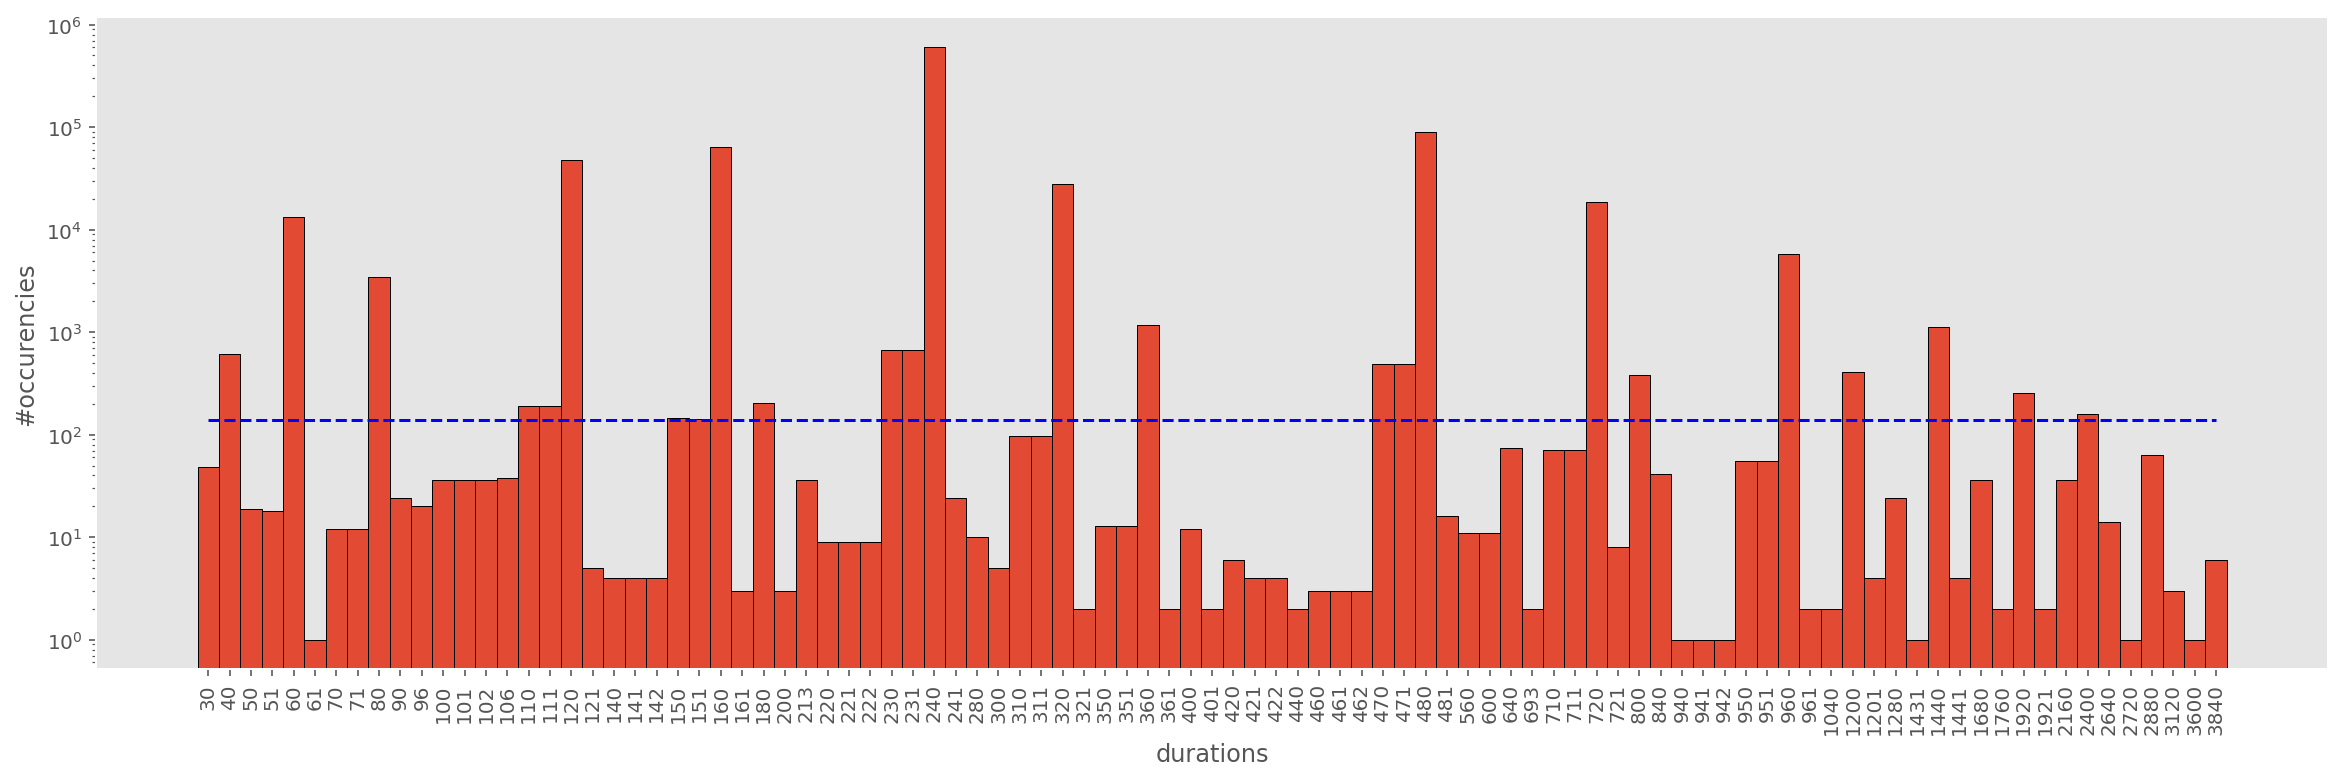

In [8]:
# Rare Event Suppression
def count_occurencies(dataset, durations, type_param):
    occurencies = dict.fromkeys(durations, 0)
    for label in list(dataset.keys()):
        for time in dataset[label][type_param]:
            occurencies[time] += 1
    return occurencies
   

def plot_histograms(durations, threshold, xlabel, show_threshold=True, rotation=90):
    fig = plt.figure(figsize = (20,6))
    durations = collections.OrderedDict(sorted(durations.items()))
    
    ax = fig.add_subplot(111)
    if show_threshold:
        horiz_line_data = np.array([threshold for i in range(len(durations.keys()))])
        ax.plot(range(len(durations.keys())), horiz_line_data, 'b--') 
    
    ax.bar(np.arange(len(durations.keys())), durations.values(), width=1, log=1, edgecolor='black')
        
    ax.set_xticks(np.arange(len(durations.keys())))
    ax.set_xticklabels(durations.keys(), rotation=rotation)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('#occurencies')
    plt.show()


threshold = 140
pitches, durations = get_all_entries(dataset)
occurencies = count_occurencies(dataset, durations, 'T')
plot_histograms(occurencies, threshold, 'durations')

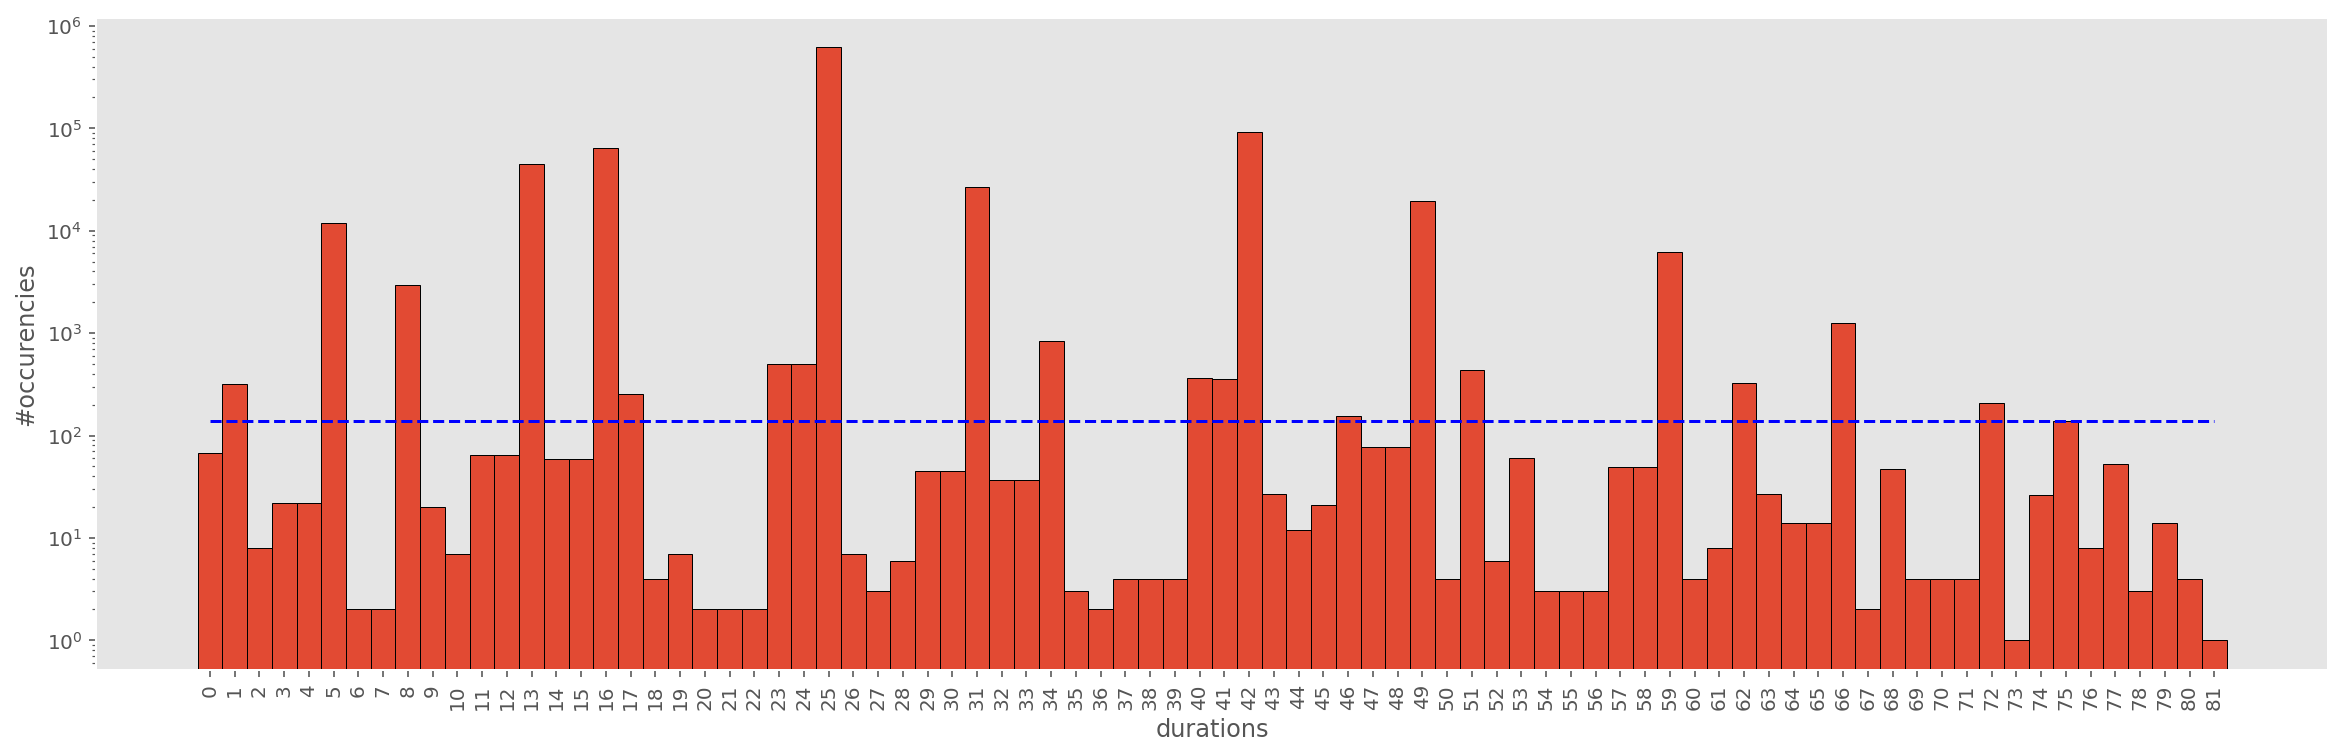

In [35]:
pitches, durations = get_all_entries(integer_dataset)
occurencies = count_occurencies(integer_dataset, durations, 'T')
plot_histograms(occurencies, threshold, 'durations')

In [36]:
def get_durations_remove(occurencies, threshold):
    to_remove = []
    for label in occurencies.keys():
        if occurencies[label] < threshold:
            to_remove.append(label)
    to_remove.sort()
    return to_remove
            
def remove_melodies(dataset, occurencies, threshold):
    new_dataset = {}
    durations_to_remove = get_durations_remove(occurencies, threshold)
    
    for label in dataset.keys():
        to_remove = False
        for time in dataset[label]['T']:
            if time in durations_to_remove:
                to_remove = True
        if not(to_remove):
            new_dataset[label] = dataset[label]
    return new_dataset

pitches, durations = get_all_entries(dataset)
occurencies = count_occurencies(dataset, durations, 'T')
new_dataset = remove_melodies(dataset, occurencies, threshold)

In [37]:
# in this way I have deleted 4.5% of melodies
print('Removed {0}% of melodies'.format(100*(1-(len(new_dataset))/float(len(dataset)))))

Removed 4.374587821499231% of melodies


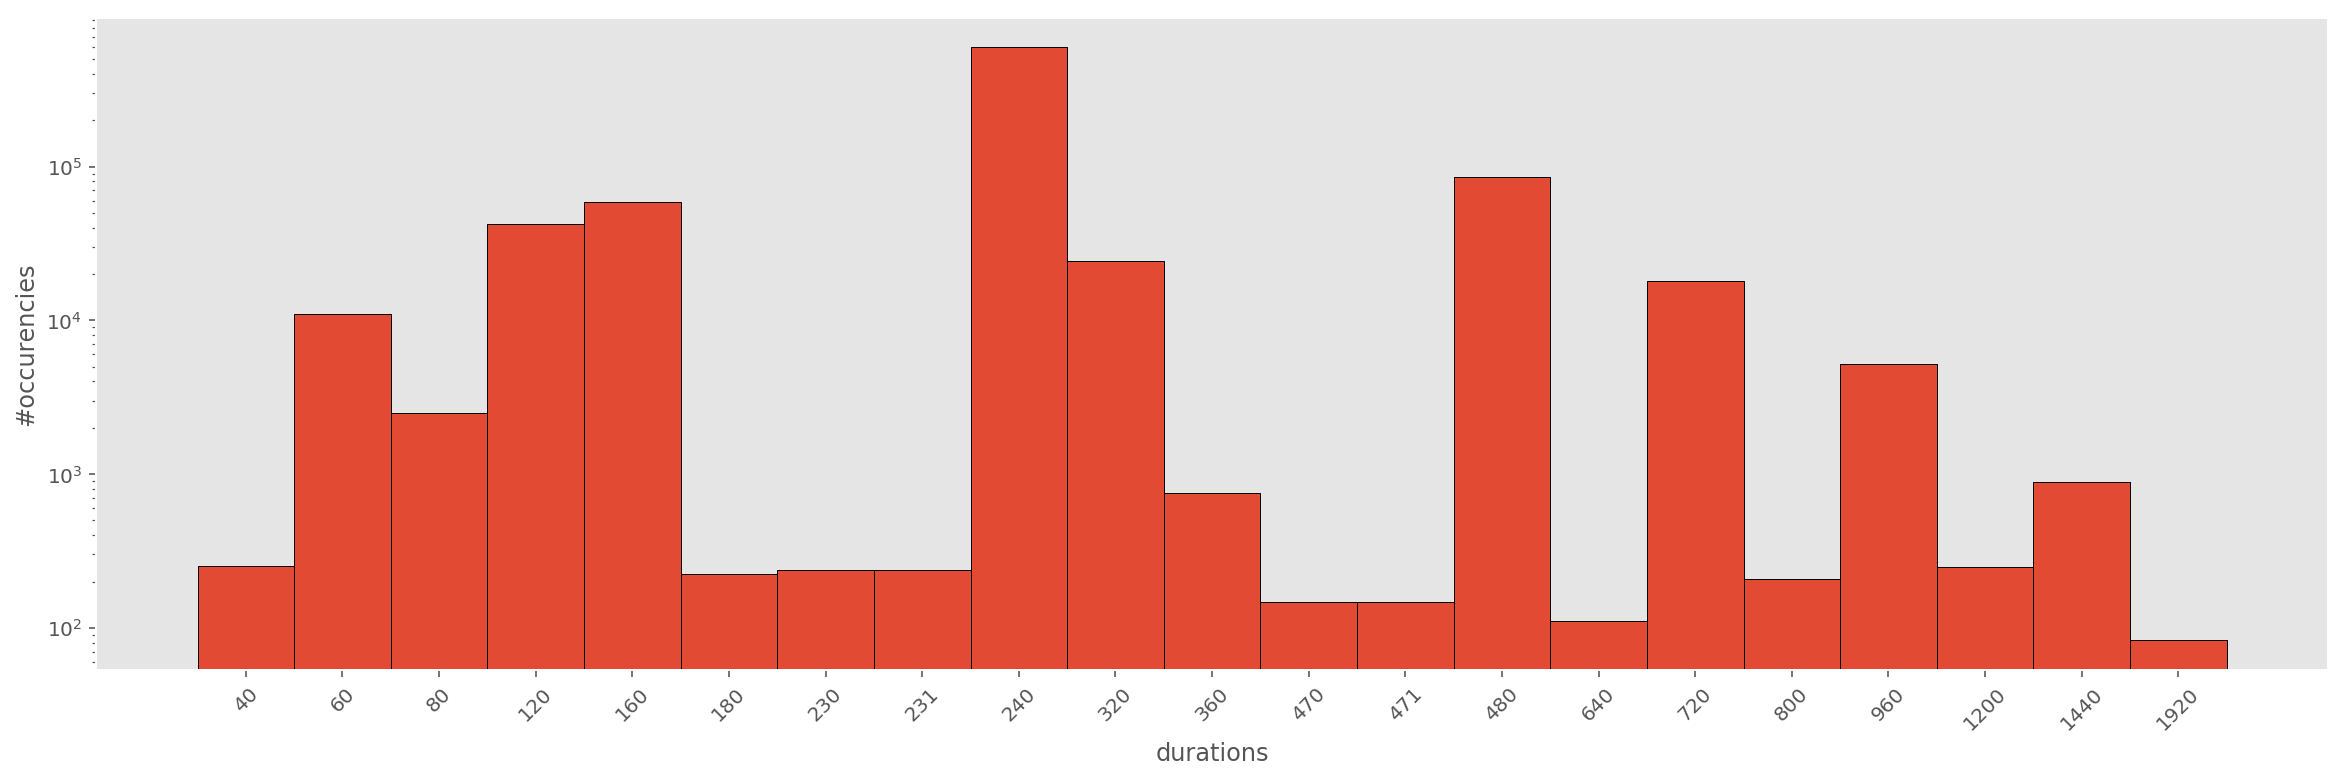

In [38]:
new_pitches, new_durations = get_all_entries(new_dataset)
new_occurencies = count_occurencies(new_dataset, new_durations, 'T')
plot_histograms(new_occurencies, threshold, 'durations', False, rotation=45)

It is correct that now there are some durations that occur less than threshold times because we have removed some melodies

### Solution

In [39]:
def transposeDataset(dataset):
    transposed_dataset = {}
    
    for label in list(dataset.keys()):
        transposed_dataset[label] = {}
        score = music21.converter.parse(datapath+label+".mid")
        key = score.analyze('key')
        if key.mode == "major":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('C'))
        elif key.mode == "minor":
            i = music21.interval.Interval(key.tonic, music21.pitch.Pitch('A'))
        i = i.semitones
        transposed_dataset[label]['P'] = [p+i for p in dataset[label]['P']]
        transposed_dataset[label]['T'] = dataset[label]['T']
        
    return transposed_dataset

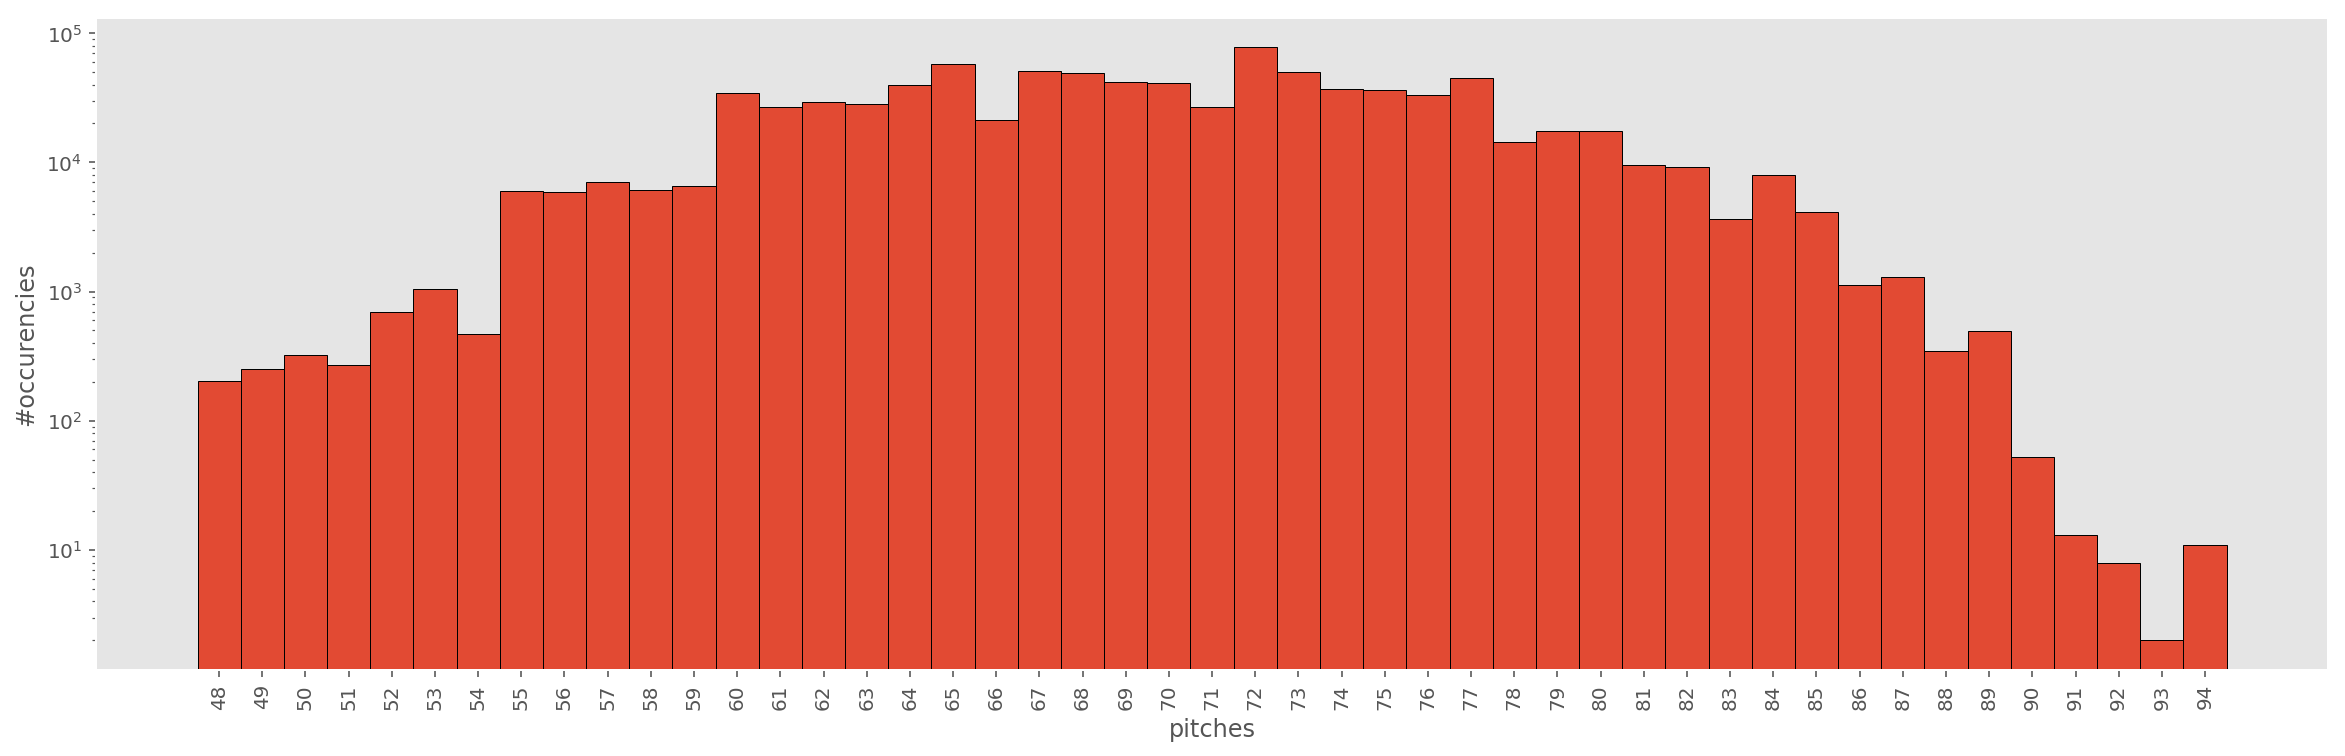

In [40]:
old_pitches_occurencies = count_occurencies(new_dataset, new_pitches, 'P')
plot_histograms(old_pitches_occurencies, threshold, 'pitches', False)

In [41]:
%%time
transposed_dataset = transposeDataset(new_dataset)

CPU times: user 12min 27s, sys: 2.94 s, total: 12min 30s
Wall time: 12min 36s


In [42]:
pitches, durations = get_all_entries(transposed_dataset)
starting_pitches_indices = get_dictionary_indexes(pitches) # from old to new
starting_durations_indices = get_dictionary_indexes(durations) # from old to new

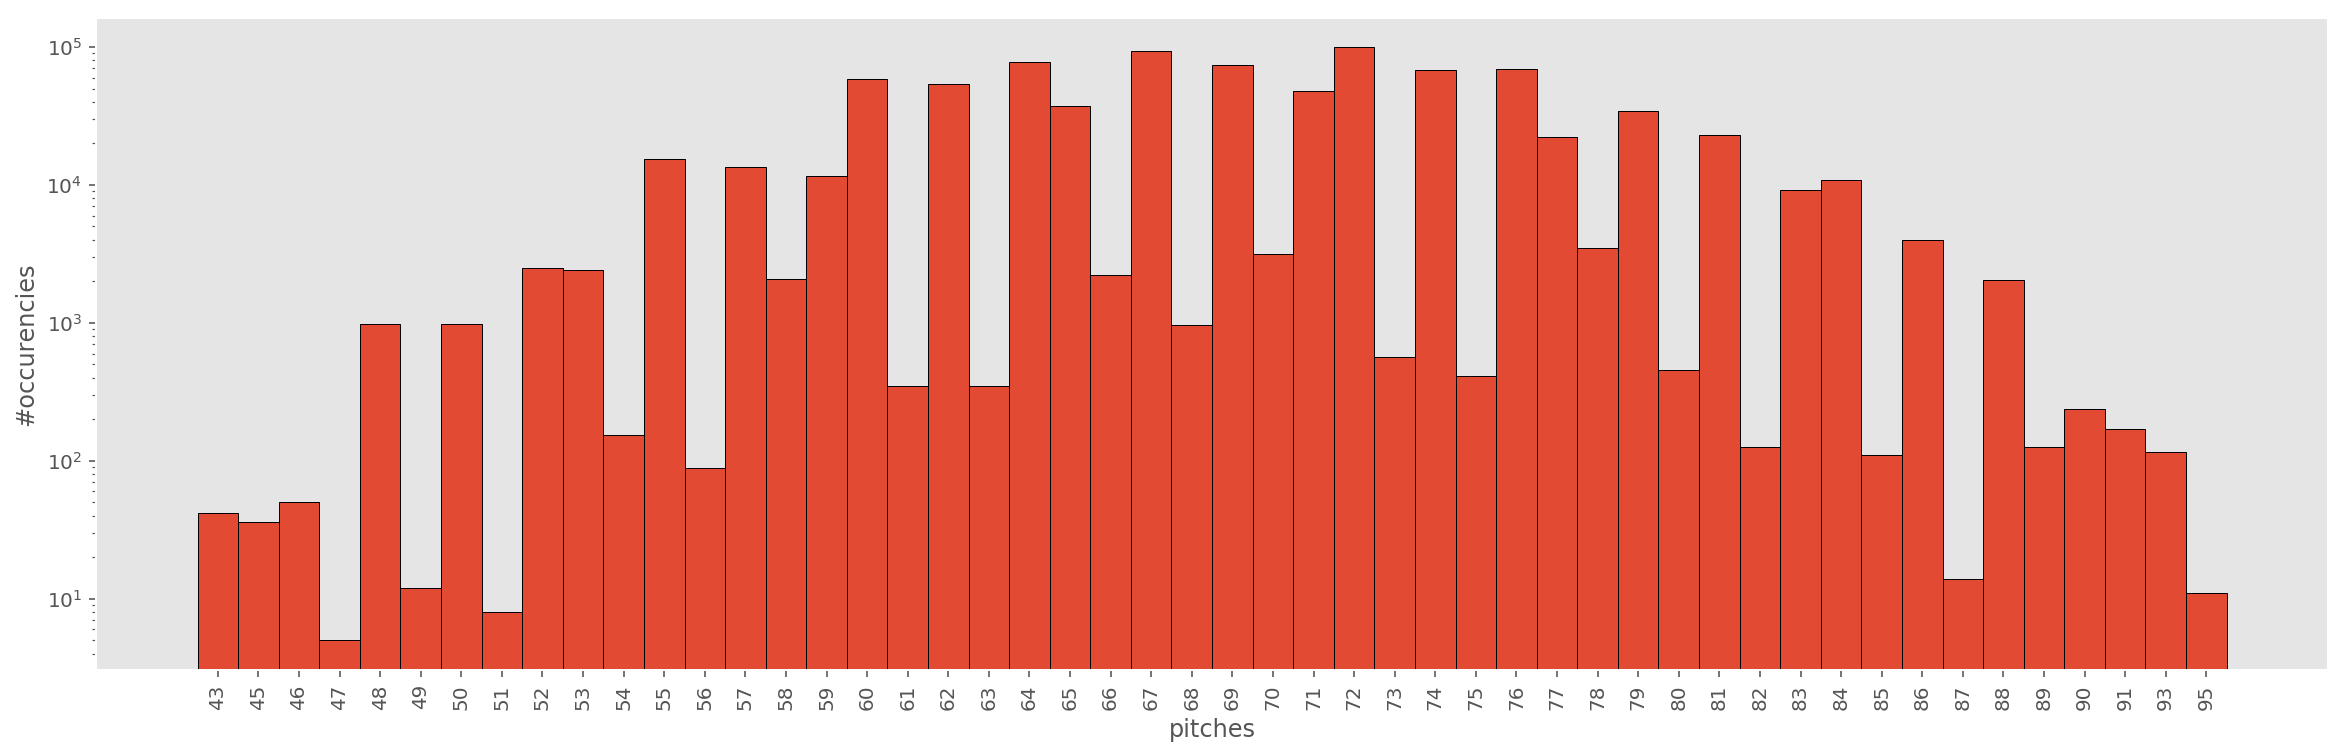

In [43]:
pitches_occurencies = count_occurencies(transposed_dataset, pitches, 'P')
plot_histograms(pitches_occurencies, threshold, 'pitches', False)

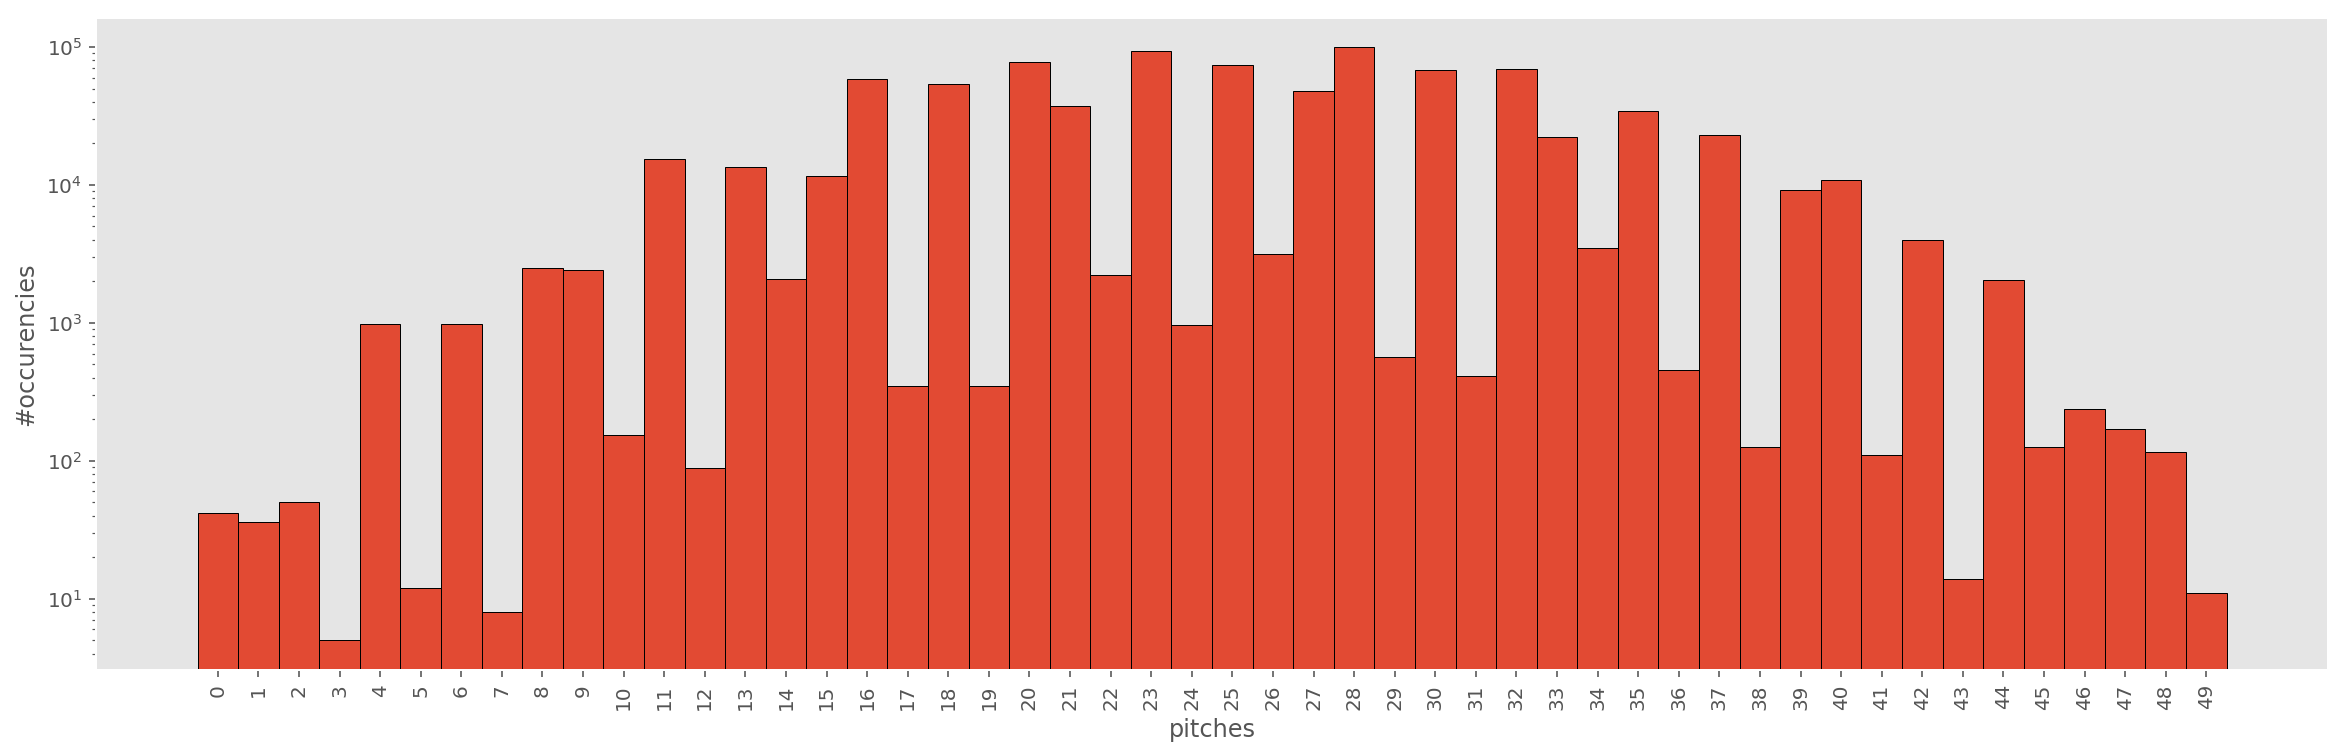

In [44]:
transposed_dataset =  get_integer_dataset(transposed_dataset)
pitches, durations = get_all_entries(transposed_dataset)
pitches_occurencies = count_occurencies(transposed_dataset, pitches, 'P')
plot_histograms(pitches_occurencies, threshold, 'pitches', False)

**Question**: How much did you reduce the space of possible durations with your rare event suppression procedure? What is the impact in term of training time?
    
**Answer**: At the beginning there were 81 different durations; at the end only 21. This has a huge impact on the training time since the input vector has been reduced four times. (maybe try to train a network without cutting off rare durations and compare times)

**Question**: Explain why and how both transposition to a single tonality and to all possible tonalities can yield transposition invariance in your model. 

**Answer**:

**Question**: In terms of number of dimensions, what would have been the impact of keeping the joint represenation of a note duration and pitch (vs separating the two features)? 

**Answer**: 

**Question**: How would the distribution of notes in the joint representation differ from the distributions in the pitch and duration only representations (as shown by your histograms above)?

**Answer**: 

## Exercise 4: One-hot and zero-padding
### Description

The last few steps to be able to feed (note by note) your music scores to a RNN model are
1. Transform the sequence of integers into a sequence of vectors in the one-hot encoding scheme.
2. Homegenize the length of each sequence

**One-hot encode** You can implement your own integer to one-hot code. For this use the numpy library and the suitable datatype. Alternatively, Keras provides a [built in one-hot encoding scheme](https://keras.io/utils/#to_categorical). After this step, for each melody, you should have two similar length matrices with one representing the sequence of note pitches and the other the sequence of note durations.
1. Code the integer representation into matrices of one-hot vectors

**Zero-padding** Most deep learning libraries, including Keras, require that you specify the shape of the input data. As such, you cannot have variable length inputs per-se. The trick to handle them is [zero-padding](https://keras.io/preprocessing/sequence/#pad_sequences). Provided with the [Masking Layer](https://keras.io/layers/core/#masking) Keras will then ignore time steps where all inputs are 0.
1. Extend the end of each melody matrices with vectors containing only zeros until all melodies have the same size. For simplicity, use the Keras pad_sequences function. There might be some rare very long melodies in your dataset, a possible choice is to set the 'maxlen' argument of pad_sequences to the mean+2std of the melody lengths. This ensure that 95% of your melodies would end before being truncated.
2. Check and display the dimension of the resulting tensors. Typically, the tensor representing the sequence of pitches should be of shape [number of melodies x number of notes x number of entries in the pitch dictionary] and the tensor representing the sequence of durations [number of melodies x number of notes x number of entries in the duration dictionary]

To check if this step was done correctly use the provided plotMelody function. For two randomly selected melodies, call the plotMelody function before and after one-hot/zero-pad. You should obtain the same plots (or slightly truncated if you randomly selected one belonging to 5% longest).

Finally, we strongly suggest that you save your preprocessed data now.

### Solution

In [45]:
def one_hot_coding_vector(dataset):
    pitches, durations = get_all_entries(dataset)
    pitches_indices = get_dictionary_indexes(pitches)
    durations_indices = get_dictionary_indexes(durations)
    one_hot_dataset = {}
    
    for label in dataset.keys():
            one_hot_dataset[label] = {"T":[], "P": []}

            P_s = dataset[label]['P']
            for i in range(len(P_s)):
                P_array = np.zeros(len(pitches_indices))
                P_array[pitches_indices[P_s[i]]] = 1
                one_hot_dataset[label]['P'].append(P_array)

            T_s = dataset[label]['T']
            for i in range(len(T_s)):
                T_array = np.zeros(len(durations_indices))
                T_array[durations_indices[T_s[i]]] = 1
                one_hot_dataset[label]['T'].append(T_array)
            
    return one_hot_dataset

# for eeach melody it returns a matrix instead of a list of pitches with dimesion (len(list_of_pitches), len(pitches_indexes))
# in this way each row corresponds to a pitch with only one 1 and zeros to represent its value
def one_hot_coding_matrix(dataset):
    pitches, durations = get_all_entries(dataset)
    pitches_indices = get_dictionary_indexes(pitches)
    durations_indices = get_dictionary_indexes(durations)
    one_hot_dataset = {}
    for label in dataset.keys():
            one_hot_dataset[label] = {"T":[], "P": []}

            P_s = dataset[label]['P']
            P_array = np.zeros((len(P_s), len(pitches_indices)))
            for i in range(len(P_s)):
                index = pitches_indices[P_s[i]]
                P_array[i][index] = 1
                
            one_hot_dataset[label]['P'] = P_array
            
            T_s = dataset[label]['T']
            T_array = np.zeros((len(T_s), len(durations_indices)))
            for i in range(len(T_s)):
                T_array[i][durations_indices[T_s[i]]] = 1
                
            one_hot_dataset[label]['T'] = T_array
            
    return one_hot_dataset

In [46]:
# one_hot_dataset1 = one_hot_coding_vector(transposed_dataset)
one_hot_dataset = one_hot_coding_matrix(transposed_dataset)

In [47]:
pitches_lengths = []

for label in one_hot_dataset.keys():
    pitches_lengths.append(one_hot_dataset[label]['P'].shape[0])
    
pitches_mean = np.mean(np.array(pitches_lengths))  
pitches_std = np.std(np.array(pitches_lengths))

In [48]:
# this method returns from a dataset made as before dataset[melody]['p'] two matrixes 
# of shape [number of melodies x number of notes x number of entries in the pitch dictionary]. The same for durations
def from_dict_to_two_np_array_y_padding(dataset, max_notes_per_melody):
    n_melodies = len(dataset)
    
    for label in dataset.keys():
        pitches_len = (dataset[label]['P'].shape[1])
        durations_len = (dataset[label]['T'].shape[1])
        break
        
    pitches_array = np.zeros((n_melodies, max_notes_per_melody, pitches_len))
    durations_array = np.zeros((n_melodies, max_notes_per_melody, durations_len))
    
    i = 0
    for label in dataset.keys():
        d_p = dataset[label]['P'][:max_notes_per_melody]
        pitches_array[i, :d_p.shape[0],:d_p.shape[1]] = d_p
        d_dur = dataset[label]['T'][:max_notes_per_melody]
        durations_array[i, :d_dur.shape[0],:d_dur.shape[1]] = d_dur
        i += 1
        
    return pitches_array, durations_array

In [49]:
pitches_dataset, durations_dataset = from_dict_to_two_np_array_y_padding(one_hot_dataset, int(pitches_mean + 2*pitches_std))

Before one hot encoding:


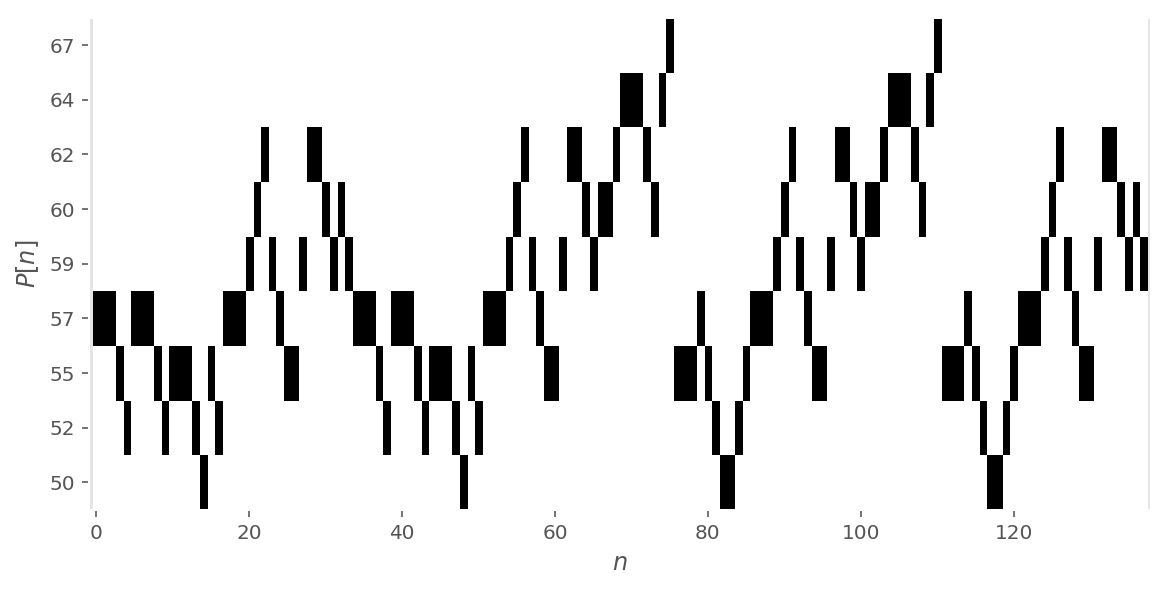

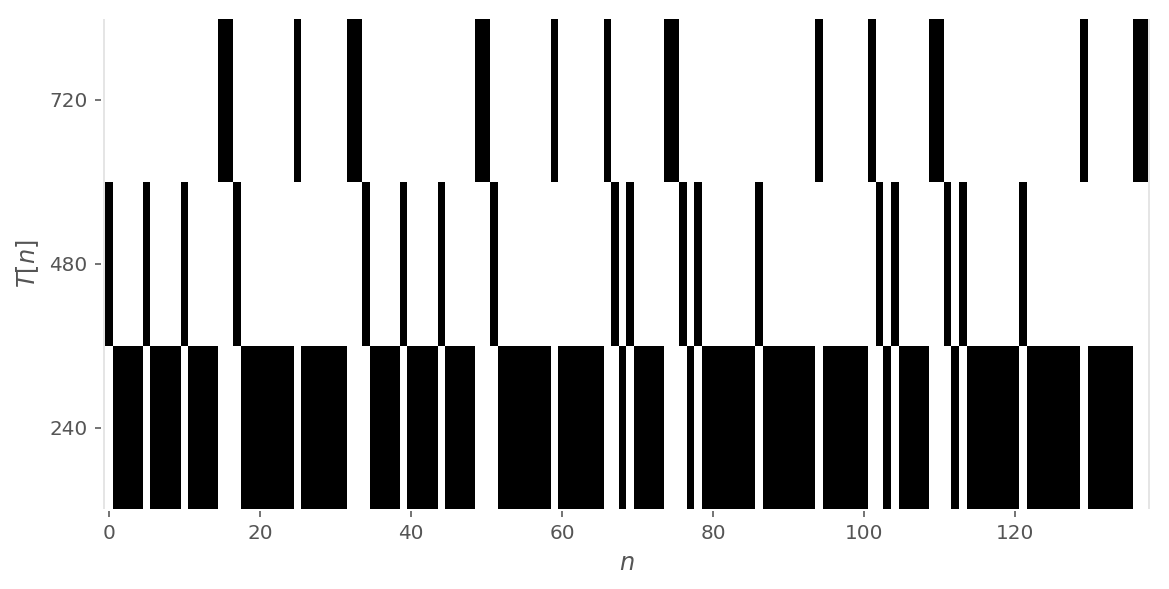

After one hot encoding:


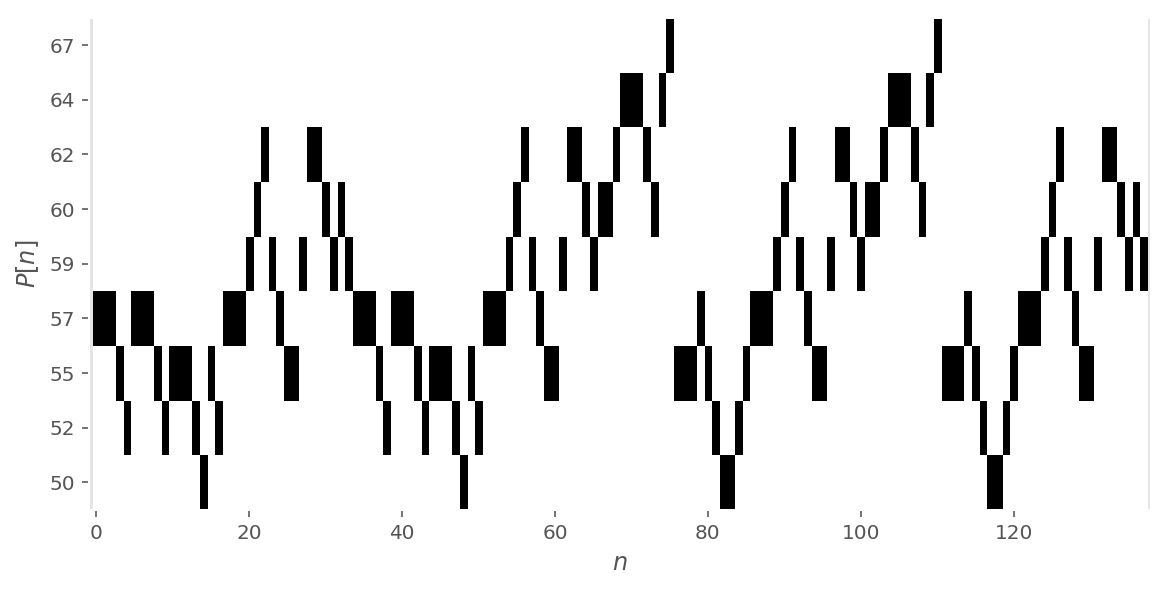

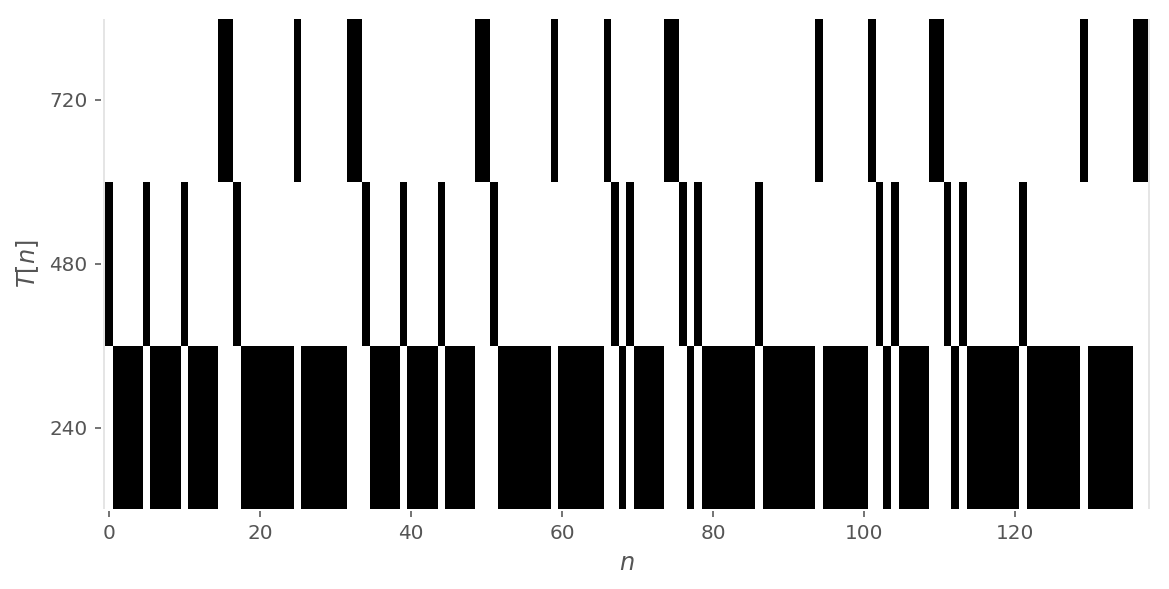

In [50]:
# check if correct with plot_melody

dict_for_plot_melody = {'P': reverse_dictionary(starting_pitches_indices), 'T': reverse_dictionary(starting_durations_indices)}
melodies_to_show = np.random.choice(list(transposed_dataset.keys()), 1)
for melody in melodies_to_show:
    print('Before one hot encoding:')
    plotMelody(transposed_dataset[melody]['P'], transposed_dataset[melody]['T'], dict_for_plot_melody)
    print('After one hot encoding:')
    plotMelody(one_hot_dataset[melody]['P'], one_hot_dataset[melody]['T'], dict_for_plot_melody)

These two set of graphs are the same, so the encoding procedure was performed correctly.

In [30]:
# store informations
with gzip.open('UsefulFiles/store_data_file', 'wb') as file:
    pickle.dump((pitches_dataset, durations_dataset, one_hot_dataset, dict_for_plot_melody), file, pickle.HIGHEST_PROTOCOL)

## Exercise 5: Building and training a generative model of  note transition with the Keras functional API
### Description

The Keras Sequential model is very efficient for fast prototyping, however suffers from a lack of design liberty. The Keras Functional API is only slightly more complex but allows for more control on the different parts of your model. You will be using the Functional API for the rest of this project. Please read carefully the [documentation](https://keras.io/getting-started/sequential-model-guide/). 

Here, you will be constructing your RNN model of note transition. To achieve that, your model should be trained to approximate the probability distribution of the upcoming note (observed as two output softmax layers - one for pitch and one for duration) given the current note (given as input) and the model internal representation of the history of notes (its hidden state). To achieve that, set the Keras RNN layer argument "return_sequences" to True when building your model. Doing this will give you an output for each note, rather than a single output at the end of the sequence. During training, the target at each time step is the next note pitch and duration.

You are free to use your own architecture but make sure to use at least 128 hidden units, Masking, and dropout to prevent overfitting. Your model should have two output (softmax) layers, one related to the pitch predictions that you should name `YP`, and the other related to the duration predictions `YT`. You should monitor both the loss (categorical_crossentropy) and the accuracy. For your best model, you should reach 40%/75% accuracy on the pitch/duration predictions.

1. Train your first model composed of SimpleRNN cells for min 250 epochs and save the model/parameters that lead to the higher accuracy on the validating set. Use a validation split of 0.2. Try  If you correctly named the output layers (`YP` and `YT`) use the provided `plotLearningCurves(History)` function to plot the learning curves by giving the History object returned by the Keras fit function as argument.  
2. Train a second model where you replaced the SimpleRNN units with GRUs (LSTM unit equivalent that requires less parameters). Make sure you use the same hyperparameters as before. Plot the learning curves.
3. On a single plot, adapt the `plotLearningCurves(History)` function to compare the validation learning curves of the simpleRNN and GRU models. In other words, plot the validation loss vs epoch for pitch/duration for the simpleRNN and GRU models. Do the same for accuracies.


### Solution

In [9]:
# load data
import gzip, pickle
with gzip.open('UsefulFiles/store_data_file', 'rb') as file:
    pitches_dataset, durations_dataset, one_hot_dataset, dict_for_plot_melody = pickle.load(file)

In [98]:
def buildModel(dictionaries, batch_length, pitches_len, durations_len, dropout=0.2, activation='GRU', Hsize=128, output_hidden_values=False):
    X = dict()
    H = dict()
    M = dict()
    Y = dict()
    
    # my input has a dimension of batch length x number of notes taken. 
    # It has just cut the first dimension of our matrix dataset
    X['T'] = Input(shape=(batch_length, durations_len), name="XT")
    X['P'] = Input(shape=(batch_length, pitches_len), name="XP")
    
    # this Masking layer is used to skip zero inputs
    M['T'] = Masking(mask_value=0., name="MT")(X['T'])
    M['P'] = Masking(mask_value=0., name="MP")(X['P'])
    
    # this layer concatenate a list of input and returns a single tensor
    # H[1].shape = (?, 53, one_hot_coding_len)
    H['1'] = Concatenate(name="MergeX")([M['T'], M['P']])
    
    if activation == 'GRU':
        out1_1 = GRU(durations_len + pitches_len, return_sequences=True, name='HiddenLayer1_1')(H['1'])
        out1 = GRU(durations_len + pitches_len, return_sequences=True, name='HiddenLayer')(out1_1)
    elif activation == 'LSTM':
        out1_1 = LSTM(int((durations_len + pitches_len)/1), return_sequences=True, name='HiddenLayer1_1')(H['1'])
        out1 = LSTM(int((durations_len + pitches_len)/4), return_sequences=True, name='HiddenLayer')(out1_1)
    elif activation == 'RNN':
        out1_1 = SimpleRNN(durations_len + pitches_len, return_sequences=True, name='HiddenLayer1_1')(H['1'])
        out1 = SimpleRNN(int((durations_len + pitches_len)/3), return_sequences=True, name='HiddenLayer')(out1_1)
    
    if output_hidden_values:
        Y['hidden'] = out1
    else:
        Y['T'] = TimeDistributed(Dense(durations_len, activation='softmax'), name='YT')(out1) #Input(s) to duration output layer
        Y['P'] = TimeDistributed(Dense(pitches_len, activation='softmax'), name='YP')(out1) #Input(s) to pitch output layer
    
    model = Model(inputs = [X['T'], X['P']], outputs = [Y['T'], Y['P']])
    opt = Adam() 
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=opt,
        metrics=['acc'])
    
    
    return model

In [99]:
dictionaries = dict()
pitches_len = len(pitches_dataset[0][0])
durations_len = len(durations_dataset[0][0])
train_input_P, train_input_T = pitches_dataset[:,:-1,:], durations_dataset[:,:-1,:]
train_target_P, train_target_T = pitches_dataset[:,1:,:], durations_dataset[:,1:,:]
dictionaries['P'], dictionaries['T'] = train_input_P, train_input_T

batch_length = train_input_P.shape[1]

batch_size=256
net_input = {'XT': train_input_T, 'XP': train_input_P}
net_output = {'YT': train_target_T, 'YP': train_target_P}

In [100]:
RNNmodel = buildModel(dictionaries, 
                      batch_length=batch_length, #Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      pitches_len = pitches_len,
                      durations_len = durations_len,
                      activation='RNN')
RNNmodel.summary()
plot_model(RNNmodel, to_file=RNNmodel.name + '.png') # summary printed at model.png

num_epochs = 200

history_RNN = RNNmodel.fit(x=net_input, y=net_output,
                       epochs=num_epochs, verbose=2, batch_size=batch_size, 
                       validation_split = 0.2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 399, 21)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 399, 50)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 399, 21)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 399, 50)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

Epoch 29/200
 - 60s - loss: 2.9073 - YT_loss: 0.7450 - YP_loss: 2.1623 - YT_acc: 0.7822 - YP_acc: 0.2503 - val_loss: 2.8880 - val_YT_loss: 0.7355 - val_YP_loss: 2.1525 - val_YT_acc: 0.7859 - val_YP_acc: 0.2470
Epoch 30/200
 - 61s - loss: 2.8870 - YT_loss: 0.7391 - YP_loss: 2.1479 - YT_acc: 0.7838 - YP_acc: 0.2535 - val_loss: 2.8691 - val_YT_loss: 0.7309 - val_YP_loss: 2.1382 - val_YT_acc: 0.7874 - val_YP_acc: 0.2506
Epoch 31/200
 - 60s - loss: 2.8679 - YT_loss: 0.7332 - YP_loss: 2.1347 - YT_acc: 0.7855 - YP_acc: 0.2569 - val_loss: 2.8512 - val_YT_loss: 0.7265 - val_YP_loss: 2.1247 - val_YT_acc: 0.7886 - val_YP_acc: 0.2546
Epoch 32/200
 - 60s - loss: 2.8490 - YT_loss: 0.7271 - YP_loss: 2.1219 - YT_acc: 0.7874 - YP_acc: 0.2615 - val_loss: 2.8332 - val_YT_loss: 0.7205 - val_YP_loss: 2.1127 - val_YT_acc: 0.7913 - val_YP_acc: 0.2598
Epoch 33/200
 - 60s - loss: 2.8322 - YT_loss: 0.7223 - YP_loss: 2.1099 - YT_acc: 0.7892 - YP_acc: 0.2656 - val_loss: 2.8181 - val_YT_loss: 0.7152 - val_YP_loss:

 - 60s - loss: 2.5496 - YT_loss: 0.6384 - YP_loss: 1.9112 - YT_acc: 0.8139 - YP_acc: 0.3425 - val_loss: 2.5562 - val_YT_loss: 0.6423 - val_YP_loss: 1.9138 - val_YT_acc: 0.8146 - val_YP_acc: 0.3389
Epoch 69/200
 - 59s - loss: 2.5468 - YT_loss: 0.6378 - YP_loss: 1.9090 - YT_acc: 0.8140 - YP_acc: 0.3427 - val_loss: 2.5535 - val_YT_loss: 0.6421 - val_YP_loss: 1.9114 - val_YT_acc: 0.8148 - val_YP_acc: 0.3390
Epoch 70/200
 - 61s - loss: 2.5436 - YT_loss: 0.6378 - YP_loss: 1.9058 - YT_acc: 0.8144 - YP_acc: 0.3440 - val_loss: 2.5514 - val_YT_loss: 0.6424 - val_YP_loss: 1.9090 - val_YT_acc: 0.8147 - val_YP_acc: 0.3408
Epoch 71/200
 - 59s - loss: 2.5396 - YT_loss: 0.6365 - YP_loss: 1.9031 - YT_acc: 0.8145 - YP_acc: 0.3451 - val_loss: 2.5481 - val_YT_loss: 0.6406 - val_YP_loss: 1.9075 - val_YT_acc: 0.8144 - val_YP_acc: 0.3411
Epoch 72/200
 - 61s - loss: 2.5349 - YT_loss: 0.6343 - YP_loss: 1.9005 - YT_acc: 0.8144 - YP_acc: 0.3461 - val_loss: 2.5420 - val_YT_loss: 0.6389 - val_YP_loss: 1.9031 - val

 - 60s - loss: 2.4464 - YT_loss: 0.6087 - YP_loss: 1.8377 - YT_acc: 0.8192 - YP_acc: 0.3660 - val_loss: 2.4618 - val_YT_loss: 0.6151 - val_YP_loss: 1.8467 - val_YT_acc: 0.8190 - val_YP_acc: 0.3624
Epoch 108/200
 - 61s - loss: 2.4439 - YT_loss: 0.6078 - YP_loss: 1.8361 - YT_acc: 0.8194 - YP_acc: 0.3673 - val_loss: 2.4611 - val_YT_loss: 0.6141 - val_YP_loss: 1.8470 - val_YT_acc: 0.8187 - val_YP_acc: 0.3612
Epoch 109/200
 - 60s - loss: 2.4430 - YT_loss: 0.6076 - YP_loss: 1.8354 - YT_acc: 0.8194 - YP_acc: 0.3671 - val_loss: 2.4581 - val_YT_loss: 0.6136 - val_YP_loss: 1.8445 - val_YT_acc: 0.8186 - val_YP_acc: 0.3625
Epoch 110/200
 - 61s - loss: 2.4410 - YT_loss: 0.6066 - YP_loss: 1.8344 - YT_acc: 0.8196 - YP_acc: 0.3670 - val_loss: 2.4636 - val_YT_loss: 0.6170 - val_YP_loss: 1.8466 - val_YT_acc: 0.8175 - val_YP_acc: 0.3604
Epoch 111/200
 - 60s - loss: 2.4424 - YT_loss: 0.6074 - YP_loss: 1.8350 - YT_acc: 0.8197 - YP_acc: 0.3672 - val_loss: 2.4567 - val_YT_loss: 0.6133 - val_YP_loss: 1.8434 -

Epoch 146/200
 - 60s - loss: 2.3947 - YT_loss: 0.5891 - YP_loss: 1.8056 - YT_acc: 0.8234 - YP_acc: 0.3756 - val_loss: 2.4149 - val_YT_loss: 0.5966 - val_YP_loss: 1.8183 - val_YT_acc: 0.8222 - val_YP_acc: 0.3700
Epoch 147/200
 - 58s - loss: 2.3924 - YT_loss: 0.5884 - YP_loss: 1.8040 - YT_acc: 0.8233 - YP_acc: 0.3763 - val_loss: 2.4125 - val_YT_loss: 0.5954 - val_YP_loss: 1.8170 - val_YT_acc: 0.8221 - val_YP_acc: 0.3701
Epoch 148/200
 - 60s - loss: 2.3901 - YT_loss: 0.5871 - YP_loss: 1.8030 - YT_acc: 0.8234 - YP_acc: 0.3764 - val_loss: 2.4136 - val_YT_loss: 0.5953 - val_YP_loss: 1.8183 - val_YT_acc: 0.8227 - val_YP_acc: 0.3700
Epoch 149/200
 - 59s - loss: 2.3904 - YT_loss: 0.5879 - YP_loss: 1.8025 - YT_acc: 0.8234 - YP_acc: 0.3765 - val_loss: 2.4133 - val_YT_loss: 0.5958 - val_YP_loss: 1.8175 - val_YT_acc: 0.8219 - val_YP_acc: 0.3716
Epoch 150/200
 - 61s - loss: 2.3913 - YT_loss: 0.5877 - YP_loss: 1.8036 - YT_acc: 0.8235 - YP_acc: 0.3759 - val_loss: 2.4123 - val_YT_loss: 0.5947 - val_YP_

Epoch 185/200
 - 59s - loss: 2.3487 - YT_loss: 0.5656 - YP_loss: 1.7831 - YT_acc: 0.8269 - YP_acc: 0.3825 - val_loss: 2.3691 - val_YT_loss: 0.5720 - val_YP_loss: 1.7971 - val_YT_acc: 0.8262 - val_YP_acc: 0.3771
Epoch 186/200
 - 61s - loss: 2.3460 - YT_loss: 0.5640 - YP_loss: 1.7820 - YT_acc: 0.8270 - YP_acc: 0.3834 - val_loss: 2.3694 - val_YT_loss: 0.5727 - val_YP_loss: 1.7967 - val_YT_acc: 0.8262 - val_YP_acc: 0.3763
Epoch 187/200
 - 61s - loss: 2.3464 - YT_loss: 0.5647 - YP_loss: 1.7816 - YT_acc: 0.8269 - YP_acc: 0.3831 - val_loss: 2.3684 - val_YT_loss: 0.5711 - val_YP_loss: 1.7973 - val_YT_acc: 0.8263 - val_YP_acc: 0.3778
Epoch 188/200
 - 60s - loss: 2.3459 - YT_loss: 0.5638 - YP_loss: 1.7821 - YT_acc: 0.8270 - YP_acc: 0.3828 - val_loss: 2.3671 - val_YT_loss: 0.5713 - val_YP_loss: 1.7958 - val_YT_acc: 0.8266 - val_YP_acc: 0.3769
Epoch 189/200
 - 60s - loss: 2.3433 - YT_loss: 0.5625 - YP_loss: 1.7807 - YT_acc: 0.8273 - YP_acc: 0.3836 - val_loss: 2.3667 - val_YT_loss: 0.5702 - val_YP_

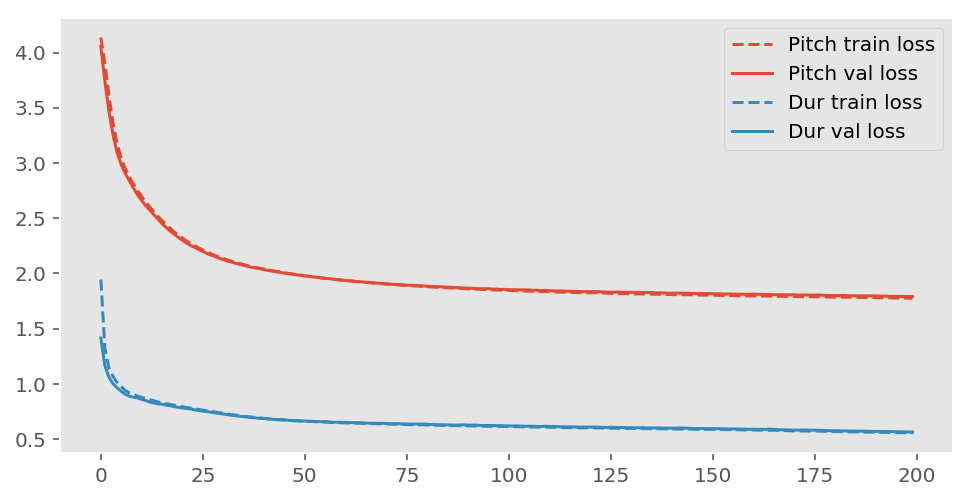

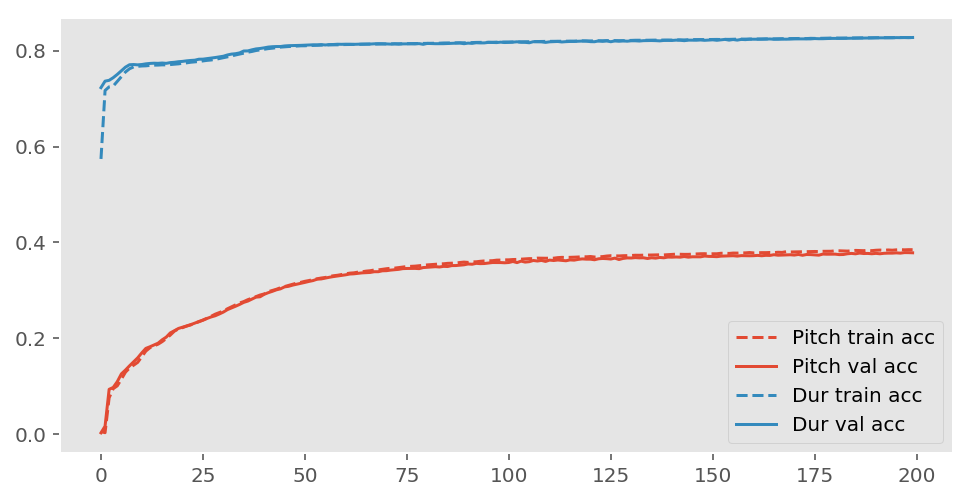

In [101]:
plotLearningCurves(history_RNN)

In [102]:
# save model and weigths to file
model_json = RNNmodel.to_json()
with open("UsefulFiles/RNNmodel.json", "w") as json_file:
    json_file.write(model_json)
RNNmodel.save_weights("UsefulFiles/RNNmodel.h5")

In [103]:
GRUmodel = buildModel(dictionaries, 
                      batch_length=batch_length, #Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      pitches_len = pitches_len,
                      durations_len = durations_len,
                      activation='GRU')
GRUmodel.summary()
plot_model(GRUmodel, to_file=GRUmodel.name + '.png') # summary printed at model.png

num_epochs = 200

history_GRU = GRUmodel.fit(x=net_input, y=net_output,
                       epochs=num_epochs, verbose=2, batch_size=batch_size, 
                       validation_split = 0.2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 399, 21)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 399, 50)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 399, 21)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 399, 50)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

Epoch 29/200
 - 113s - loss: 2.5604 - YT_loss: 0.6450 - YP_loss: 1.9153 - YT_acc: 0.8077 - YP_acc: 0.3359 - val_loss: 2.5574 - val_YT_loss: 0.6458 - val_YP_loss: 1.9116 - val_YT_acc: 0.8093 - val_YP_acc: 0.3349
Epoch 30/200
 - 112s - loss: 2.5504 - YT_loss: 0.6430 - YP_loss: 1.9073 - YT_acc: 0.8085 - YP_acc: 0.3389 - val_loss: 2.5480 - val_YT_loss: 0.6433 - val_YP_loss: 1.9047 - val_YT_acc: 0.8102 - val_YP_acc: 0.3375
Epoch 31/200
 - 114s - loss: 2.5410 - YT_loss: 0.6402 - YP_loss: 1.9007 - YT_acc: 0.8090 - YP_acc: 0.3404 - val_loss: 2.5388 - val_YT_loss: 0.6416 - val_YP_loss: 1.8972 - val_YT_acc: 0.8115 - val_YP_acc: 0.3397
Epoch 32/200
 - 114s - loss: 2.5314 - YT_loss: 0.6380 - YP_loss: 1.8935 - YT_acc: 0.8099 - YP_acc: 0.3434 - val_loss: 2.5298 - val_YT_loss: 0.6394 - val_YP_loss: 1.8904 - val_YT_acc: 0.8124 - val_YP_acc: 0.3425
Epoch 33/200
 - 113s - loss: 2.5225 - YT_loss: 0.6356 - YP_loss: 1.8869 - YT_acc: 0.8106 - YP_acc: 0.3454 - val_loss: 2.5217 - val_YT_loss: 0.6374 - val_YP_

Epoch 68/200
 - 114s - loss: 2.3240 - YT_loss: 0.5742 - YP_loss: 1.7497 - YT_acc: 0.8238 - YP_acc: 0.3901 - val_loss: 2.3365 - val_YT_loss: 0.5796 - val_YP_loss: 1.7569 - val_YT_acc: 0.8229 - val_YP_acc: 0.3848
Epoch 69/200
 - 112s - loss: 2.3194 - YT_loss: 0.5724 - YP_loss: 1.7469 - YT_acc: 0.8242 - YP_acc: 0.3907 - val_loss: 2.3323 - val_YT_loss: 0.5782 - val_YP_loss: 1.7541 - val_YT_acc: 0.8233 - val_YP_acc: 0.3848
Epoch 70/200
 - 112s - loss: 2.3146 - YT_loss: 0.5705 - YP_loss: 1.7441 - YT_acc: 0.8246 - YP_acc: 0.3920 - val_loss: 2.3286 - val_YT_loss: 0.5767 - val_YP_loss: 1.7519 - val_YT_acc: 0.8235 - val_YP_acc: 0.3859
Epoch 71/200
 - 113s - loss: 2.3105 - YT_loss: 0.5689 - YP_loss: 1.7416 - YT_acc: 0.8246 - YP_acc: 0.3927 - val_loss: 2.3247 - val_YT_loss: 0.5750 - val_YP_loss: 1.7497 - val_YT_acc: 0.8234 - val_YP_acc: 0.3872
Epoch 72/200
 - 112s - loss: 2.3062 - YT_loss: 0.5667 - YP_loss: 1.7395 - YT_acc: 0.8251 - YP_acc: 0.3942 - val_loss: 2.3203 - val_YT_loss: 0.5730 - val_YP_

Epoch 107/200
 - 114s - loss: 2.1730 - YT_loss: 0.5179 - YP_loss: 1.6551 - YT_acc: 0.8312 - YP_acc: 0.4244 - val_loss: 2.2082 - val_YT_loss: 0.5291 - val_YP_loss: 1.6792 - val_YT_acc: 0.8309 - val_YP_acc: 0.4164
Epoch 108/200
 - 112s - loss: 2.1699 - YT_loss: 0.5168 - YP_loss: 1.6531 - YT_acc: 0.8311 - YP_acc: 0.4253 - val_loss: 2.2064 - val_YT_loss: 0.5286 - val_YP_loss: 1.6779 - val_YT_acc: 0.8309 - val_YP_acc: 0.4157
Epoch 109/200
 - 114s - loss: 2.1667 - YT_loss: 0.5158 - YP_loss: 1.6509 - YT_acc: 0.8315 - YP_acc: 0.4259 - val_loss: 2.2029 - val_YT_loss: 0.5277 - val_YP_loss: 1.6752 - val_YT_acc: 0.8313 - val_YP_acc: 0.4170
Epoch 110/200
 - 113s - loss: 2.1634 - YT_loss: 0.5147 - YP_loss: 1.6487 - YT_acc: 0.8316 - YP_acc: 0.4266 - val_loss: 2.2008 - val_YT_loss: 0.5268 - val_YP_loss: 1.6740 - val_YT_acc: 0.8314 - val_YP_acc: 0.4171
Epoch 111/200
 - 113s - loss: 2.1603 - YT_loss: 0.5136 - YP_loss: 1.6467 - YT_acc: 0.8318 - YP_acc: 0.4277 - val_loss: 2.1981 - val_YT_loss: 0.5262 - va

Epoch 146/200
 - 113s - loss: 2.0670 - YT_loss: 0.4859 - YP_loss: 1.5811 - YT_acc: 0.8362 - YP_acc: 0.4512 - val_loss: 2.1300 - val_YT_loss: 0.5042 - val_YP_loss: 1.6258 - val_YT_acc: 0.8342 - val_YP_acc: 0.4353
Epoch 147/200
 - 114s - loss: 2.0655 - YT_loss: 0.4856 - YP_loss: 1.5800 - YT_acc: 0.8361 - YP_acc: 0.4518 - val_loss: 2.1284 - val_YT_loss: 0.5043 - val_YP_loss: 1.6241 - val_YT_acc: 0.8341 - val_YP_acc: 0.4354
Epoch 148/200
 - 113s - loss: 2.0633 - YT_loss: 0.4850 - YP_loss: 1.5783 - YT_acc: 0.8363 - YP_acc: 0.4522 - val_loss: 2.1281 - val_YT_loss: 0.5034 - val_YP_loss: 1.6247 - val_YT_acc: 0.8343 - val_YP_acc: 0.4360
Epoch 149/200
 - 113s - loss: 2.0610 - YT_loss: 0.4845 - YP_loss: 1.5765 - YT_acc: 0.8365 - YP_acc: 0.4529 - val_loss: 2.1256 - val_YT_loss: 0.5035 - val_YP_loss: 1.6222 - val_YT_acc: 0.8343 - val_YP_acc: 0.4363
Epoch 150/200
 - 112s - loss: 2.0588 - YT_loss: 0.4839 - YP_loss: 1.5749 - YT_acc: 0.8365 - YP_acc: 0.4535 - val_loss: 2.1231 - val_YT_loss: 0.5023 - va

Epoch 185/200
 - 113s - loss: 1.9977 - YT_loss: 0.4703 - YP_loss: 1.5273 - YT_acc: 0.8390 - YP_acc: 0.4709 - val_loss: 2.0927 - val_YT_loss: 0.4956 - val_YP_loss: 1.5971 - val_YT_acc: 0.8348 - val_YP_acc: 0.4474
Epoch 186/200
 - 115s - loss: 1.9993 - YT_loss: 0.4713 - YP_loss: 1.5280 - YT_acc: 0.8389 - YP_acc: 0.4703 - val_loss: 2.0913 - val_YT_loss: 0.4948 - val_YP_loss: 1.5964 - val_YT_acc: 0.8351 - val_YP_acc: 0.4469
Epoch 187/200
 - 115s - loss: 1.9949 - YT_loss: 0.4697 - YP_loss: 1.5253 - YT_acc: 0.8389 - YP_acc: 0.4709 - val_loss: 2.0903 - val_YT_loss: 0.4947 - val_YP_loss: 1.5957 - val_YT_acc: 0.8351 - val_YP_acc: 0.4469
Epoch 188/200
 - 117s - loss: 1.9933 - YT_loss: 0.4697 - YP_loss: 1.5236 - YT_acc: 0.8391 - YP_acc: 0.4720 - val_loss: 2.0889 - val_YT_loss: 0.4943 - val_YP_loss: 1.5946 - val_YT_acc: 0.8353 - val_YP_acc: 0.4472
Epoch 189/200
 - 114s - loss: 1.9911 - YT_loss: 0.4688 - YP_loss: 1.5223 - YT_acc: 0.8392 - YP_acc: 0.4720 - val_loss: 2.0866 - val_YT_loss: 0.4936 - va

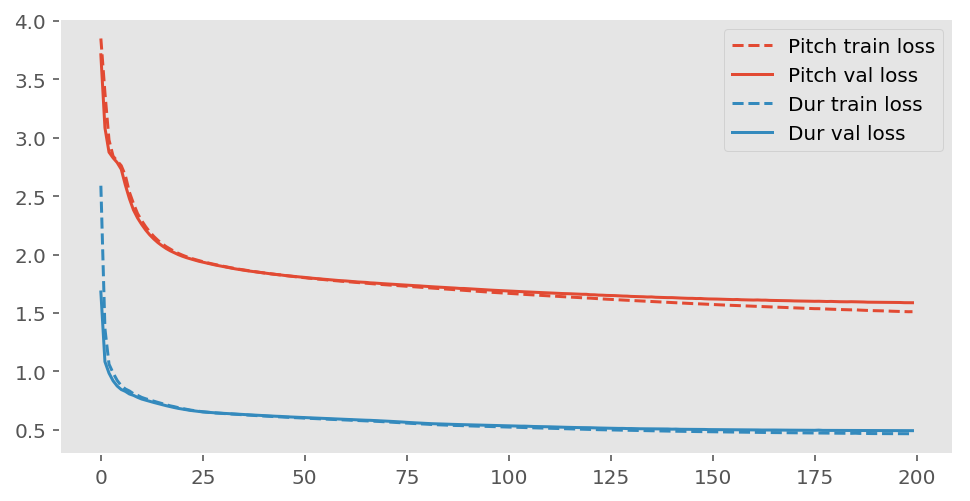

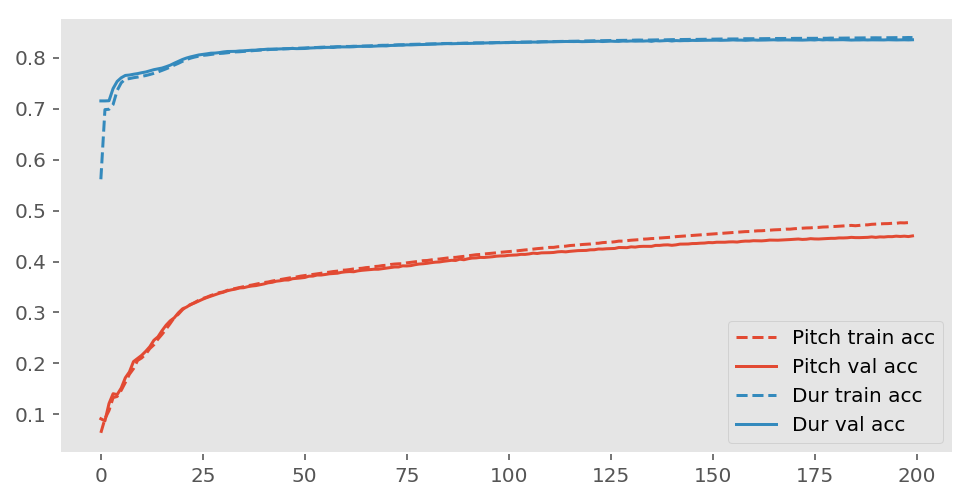

In [104]:
plotLearningCurves(history_GRU)

In [105]:
# save model and weigths to file
model_json = GRUmodel.to_json()
with open("UsefulFiles/GRUmodel.json", "w") as json_file:
    json_file.write(model_json)
GRUmodel.save_weights("UsefulFiles/GRUmodel.h5")

In [106]:
LSTMmodel = buildModel(dictionaries, 
                      batch_length=batch_length, #Put here the number of notes (timesteps) you have in your Zero-padded matrices
                      pitches_len = pitches_len,
                      durations_len = durations_len,
                      activation='LSTM')
LSTMmodel.summary()
plot_model(LSTMmodel, to_file=LSTMmodel.name + '.png') # summary printed at model.png

num_epochs = 150

history_LSTM = LSTMmodel.fit(x=net_input, y=net_output,
                       epochs=num_epochs, verbose=2, batch_size=batch_size, 
                       validation_split = 0.2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
XT (InputLayer)                 (None, 399, 21)      0                                            
__________________________________________________________________________________________________
XP (InputLayer)                 (None, 399, 50)      0                                            
__________________________________________________________________________________________________
MT (Masking)                    (None, 399, 21)      0           XT[0][0]                         
__________________________________________________________________________________________________
MP (Masking)                    (None, 399, 50)      0           XP[0][0]                         
__________________________________________________________________________________________________
MergeX (Co

Epoch 29/150
 - 97s - loss: 3.7262 - YT_loss: 0.9524 - YP_loss: 2.7739 - YT_acc: 0.6980 - YP_acc: 0.1351 - val_loss: 3.6842 - val_YT_loss: 0.9135 - val_YP_loss: 2.7707 - val_YT_acc: 0.7154 - val_YP_acc: 0.1342
Epoch 30/150
 - 96s - loss: 3.7077 - YT_loss: 0.9405 - YP_loss: 2.7672 - YT_acc: 0.6982 - YP_acc: 0.1368 - val_loss: 3.6686 - val_YT_loss: 0.9058 - val_YP_loss: 2.7628 - val_YT_acc: 0.7154 - val_YP_acc: 0.1351
Epoch 31/150
 - 96s - loss: 3.6928 - YT_loss: 0.9331 - YP_loss: 2.7597 - YT_acc: 0.6981 - YP_acc: 0.1377 - val_loss: 3.6522 - val_YT_loss: 0.8992 - val_YP_loss: 2.7530 - val_YT_acc: 0.7154 - val_YP_acc: 0.1377
Epoch 32/150
 - 97s - loss: 3.6731 - YT_loss: 0.9278 - YP_loss: 2.7453 - YT_acc: 0.6981 - YP_acc: 0.1393 - val_loss: 3.6335 - val_YT_loss: 0.8946 - val_YP_loss: 2.7389 - val_YT_acc: 0.7154 - val_YP_acc: 0.1381
Epoch 33/150
 - 98s - loss: 3.6522 - YT_loss: 0.9247 - YP_loss: 2.7275 - YT_acc: 0.6982 - YP_acc: 0.1398 - val_loss: 3.6101 - val_YT_loss: 0.8945 - val_YP_loss:

Epoch 68/150
 - 63s - loss: 3.2309 - YT_loss: 0.8340 - YP_loss: 2.3969 - YT_acc: 0.7490 - YP_acc: 0.1963 - val_loss: 3.2022 - val_YT_loss: 0.8081 - val_YP_loss: 2.3941 - val_YT_acc: 0.7561 - val_YP_acc: 0.1952
Epoch 69/150
 - 63s - loss: 3.2220 - YT_loss: 0.8304 - YP_loss: 2.3915 - YT_acc: 0.7504 - YP_acc: 0.1970 - val_loss: 3.1948 - val_YT_loss: 0.8058 - val_YP_loss: 2.3890 - val_YT_acc: 0.7588 - val_YP_acc: 0.1959
Epoch 70/150
 - 63s - loss: 3.2150 - YT_loss: 0.8291 - YP_loss: 2.3859 - YT_acc: 0.7520 - YP_acc: 0.1980 - val_loss: 3.1876 - val_YT_loss: 0.8054 - val_YP_loss: 2.3823 - val_YT_acc: 0.7588 - val_YP_acc: 0.1973
Epoch 71/150
 - 62s - loss: 3.2071 - YT_loss: 0.8268 - YP_loss: 2.3803 - YT_acc: 0.7536 - YP_acc: 0.1980 - val_loss: 3.1802 - val_YT_loss: 0.8029 - val_YP_loss: 2.3773 - val_YT_acc: 0.7609 - val_YP_acc: 0.1965
Epoch 72/150
 - 63s - loss: 3.2006 - YT_loss: 0.8252 - YP_loss: 2.3754 - YT_acc: 0.7543 - YP_acc: 0.1984 - val_loss: 3.1737 - val_YT_loss: 0.8014 - val_YP_loss:

Epoch 107/150
 - 75s - loss: 3.0491 - YT_loss: 0.7775 - YP_loss: 2.2716 - YT_acc: 0.7781 - YP_acc: 0.2031 - val_loss: 3.0283 - val_YT_loss: 0.7587 - val_YP_loss: 2.2695 - val_YT_acc: 0.7857 - val_YP_acc: 0.2004
Epoch 108/150
 - 65s - loss: 3.0453 - YT_loss: 0.7761 - YP_loss: 2.2692 - YT_acc: 0.7784 - YP_acc: 0.2035 - val_loss: 3.0246 - val_YT_loss: 0.7567 - val_YP_loss: 2.2679 - val_YT_acc: 0.7853 - val_YP_acc: 0.2012
Epoch 109/150
 - 67s - loss: 3.0417 - YT_loss: 0.7753 - YP_loss: 2.2663 - YT_acc: 0.7785 - YP_acc: 0.2040 - val_loss: 3.0213 - val_YT_loss: 0.7565 - val_YP_loss: 2.2648 - val_YT_acc: 0.7853 - val_YP_acc: 0.1994
Epoch 110/150
 - 68s - loss: 3.0375 - YT_loss: 0.7736 - YP_loss: 2.2638 - YT_acc: 0.7788 - YP_acc: 0.2037 - val_loss: 3.0178 - val_YT_loss: 0.7555 - val_YP_loss: 2.2623 - val_YT_acc: 0.7860 - val_YP_acc: 0.2018
Epoch 111/150
 - 64s - loss: 3.0345 - YT_loss: 0.7733 - YP_loss: 2.2612 - YT_acc: 0.7789 - YP_acc: 0.2035 - val_loss: 3.0143 - val_YT_loss: 0.7557 - val_YP_

Epoch 146/150
 - 66s - loss: 2.9267 - YT_loss: 0.7560 - YP_loss: 2.1708 - YT_acc: 0.7797 - YP_acc: 0.2272 - val_loss: 2.9090 - val_YT_loss: 0.7392 - val_YP_loss: 2.1699 - val_YT_acc: 0.7871 - val_YP_acc: 0.2290
Epoch 147/150
 - 65s - loss: 2.9247 - YT_loss: 0.7558 - YP_loss: 2.1690 - YT_acc: 0.7797 - YP_acc: 0.2278 - val_loss: 2.9068 - val_YT_loss: 0.7397 - val_YP_loss: 2.1671 - val_YT_acc: 0.7871 - val_YP_acc: 0.2272
Epoch 148/150
 - 70s - loss: 2.9217 - YT_loss: 0.7553 - YP_loss: 2.1664 - YT_acc: 0.7797 - YP_acc: 0.2278 - val_loss: 2.9037 - val_YT_loss: 0.7392 - val_YP_loss: 2.1645 - val_YT_acc: 0.7874 - val_YP_acc: 0.2277
Epoch 149/150
 - 66s - loss: 2.9189 - YT_loss: 0.7546 - YP_loss: 2.1643 - YT_acc: 0.7799 - YP_acc: 0.2279 - val_loss: 2.9014 - val_YT_loss: 0.7387 - val_YP_loss: 2.1627 - val_YT_acc: 0.7871 - val_YP_acc: 0.2282
Epoch 150/150
 - 68s - loss: 2.9168 - YT_loss: 0.7543 - YP_loss: 2.1625 - YT_acc: 0.7799 - YP_acc: 0.2283 - val_loss: 2.8998 - val_YT_loss: 0.7391 - val_YP_

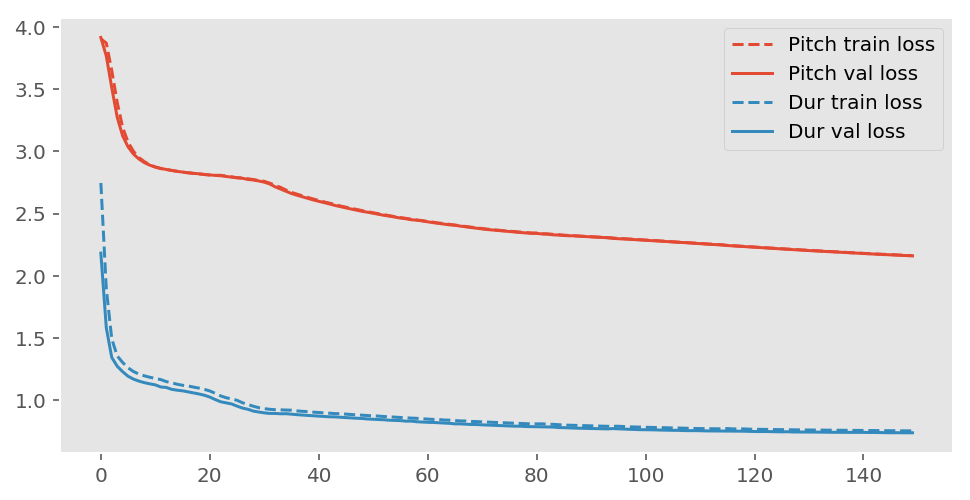

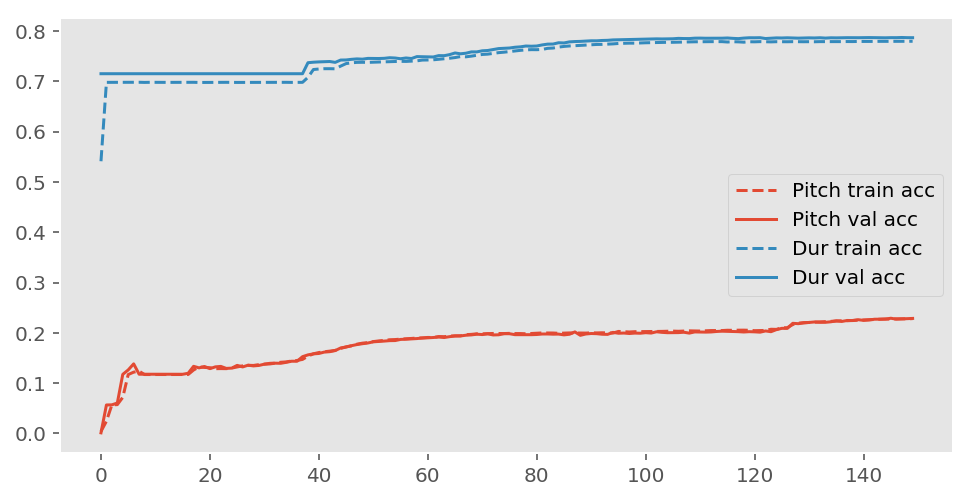

In [107]:
plotLearningCurves(history_LSTM)

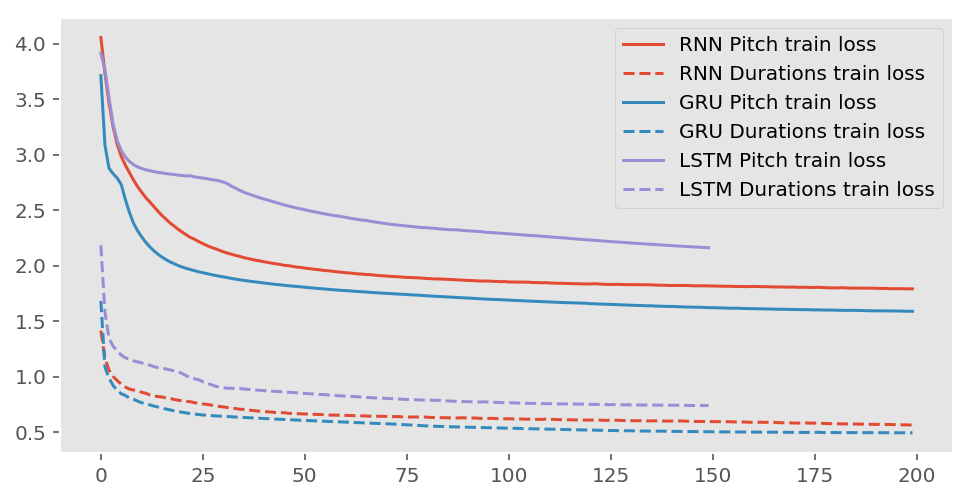

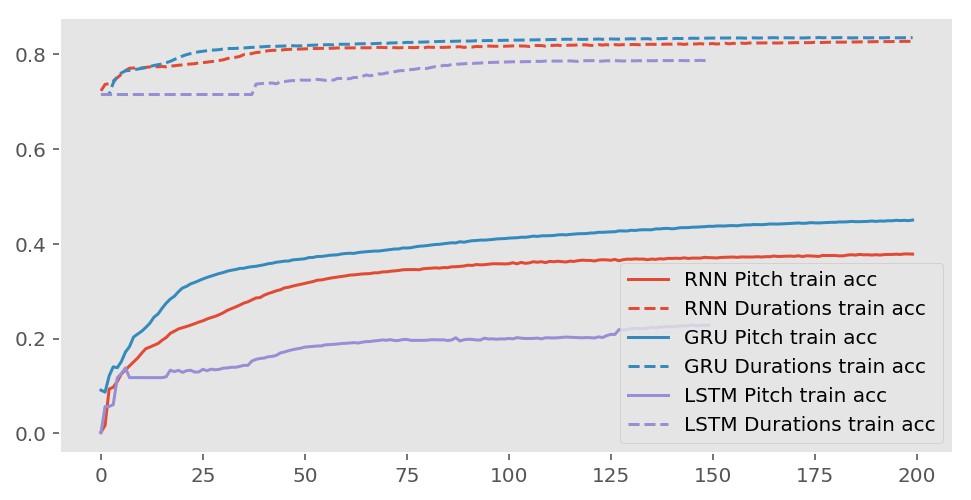

In [108]:
plotLearningCurvesMoreHistories([history_RNN, history_GRU, history_LSTM], ['RNN', 'GRU', 'LSTM'])

In [109]:
# save model and weigths to file
model_json = LSTMmodel.to_json()
with open("UsefulFiles/LSTMmodel.json", "w") as json_file:
    json_file.write(model_json)
LSTMmodel.save_weights("UsefulFiles/LSTMmodel.h5")

**Question**: What are the best prediction accuracies you obtained? With which model?
    
**Answer**: 

**Question**: In a few sentences, comment on the plot comparing learning curves for the two activation function.
    
**Answer**: 



## Exercise 6: Visualizing the model
### Description

1. Using the model.predict and plotMelody functions, show the outputs of your best model when fed with 4 randomly selected melodies. Report the prediction accuracies as well.
2. For the same melodies, plot the hidden state evolution accross time steps. Construct a 2 dimensional matrix with the first dimension being time and the second the concatenation of all hidden unit activations and plot it using the provided `plotMelody` function. To get the hidden states of your network, you can modify the `buildModel` function so that you have another computation graph (another model with the same layers, but the output layer) returning you the hidden states. However, other approaches are equally valid.  
3. For each hidden unit $i$ and accross the entire dataset, compute the average absolute change in activation $\Delta A_i$. Be careful not to take masked timesteps into account. Plot the histogram (50 bins) of this average for the RNN and GRU models on the same figure.

### Solution

In [110]:
# load models from file
json_file = open('UsefulFiles/RNNmodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("UsefulFiles/RNNmodel.h5")
RNNmodel = loaded_model


json_file = open('UsefulFiles/GRUmodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("UsefulFiles/GRUmodel.h5")
GRUmodel = loaded_model


json_file = open('UsefulFiles/LSTMmodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("UsefulFiles/LSTMmodel.h5")
LSTMmodel = loaded_model

In [111]:
best_model = GRUmodel # change the best model here

In [112]:
import heapq, random
def make_one_hot_econding(arr, one_more_line=False):
    if one_more_line:
        to_ret = np.zeros((arr.shape[0] + 1, arr.shape[1]))
    else:
        to_ret = np.zeros(arr.shape)
    found = False
    for i in range(len(arr)):
        if np.mean(arr[i]) == 0 and not found:
            found = True
            max_val = i
        # in this way I use the probability produced by softmax function in output
        best_index = np.random.choice(np.arange(0, len(arr[i])), p=arr[i])
        to_ret[i][best_index] = 1
#       to_ret[i][arr[i].argmax()] = 1
    return to_ret[:(i+1)]


def get_avg_array(inter_array):
    total = 0
    for i in range(len(inter_array)-1):
        total += np.abs(inter_array[i] - inter_array[i+1])
    return total/float(len(inter_array)-1)
                   
                  
def get_avg_out(inter_out):
    # input of shape (3261, 363, 60), output should be (60)
    first_step = np.zeros((inter_out.shape[0], inter_out.shape[2]))
    for i in range(inter_out.shape[0]):
        list_avgs = []
        for j in range(inter_out[i].shape[1]):
            list_avgs.append(get_avg_array(inter_out[i,:,j]))
        first_step[i] = np.asarray(list_avgs)
    
    to_ret = []
    for i in range(first_step.shape[1]):
        to_ret.append(get_avg_array(first_step[:,i]))
    return np.asarray(to_ret)



Real:


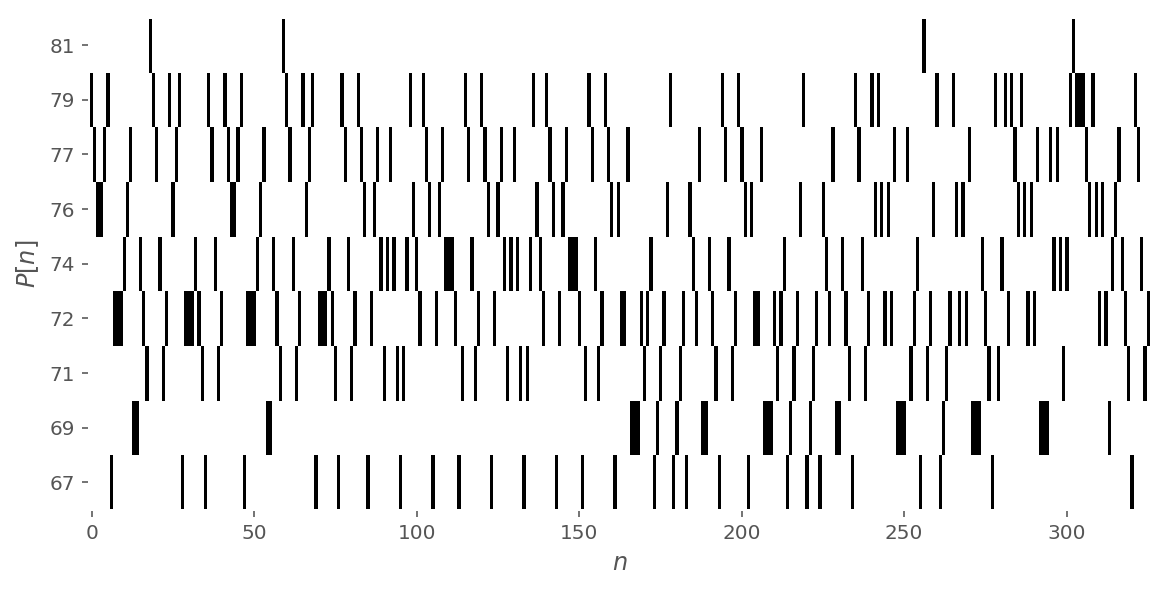

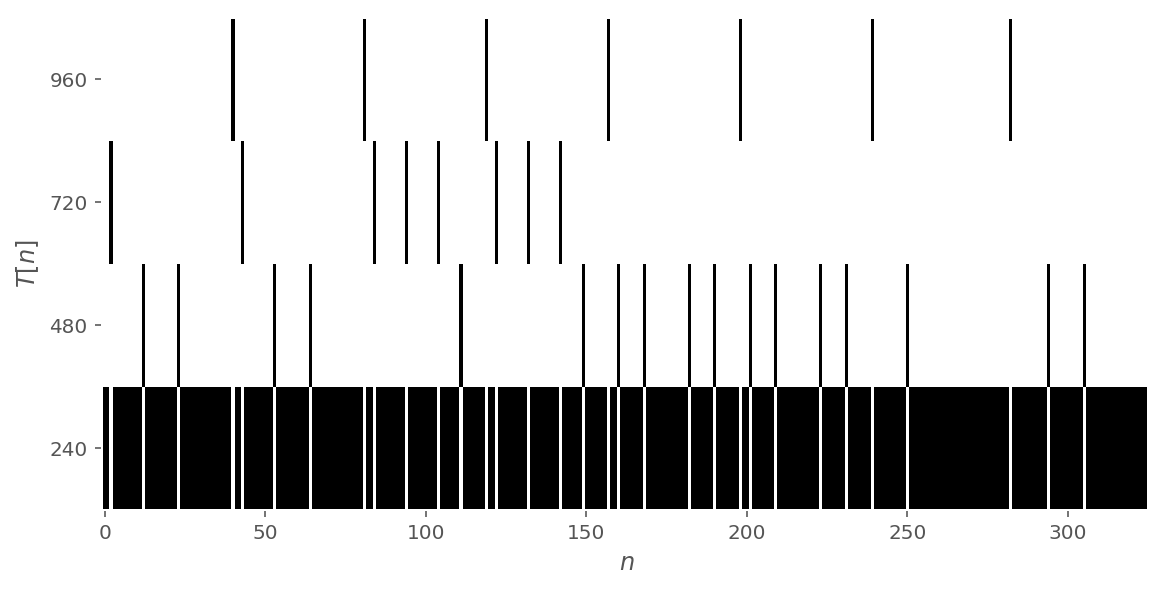

Predicted:


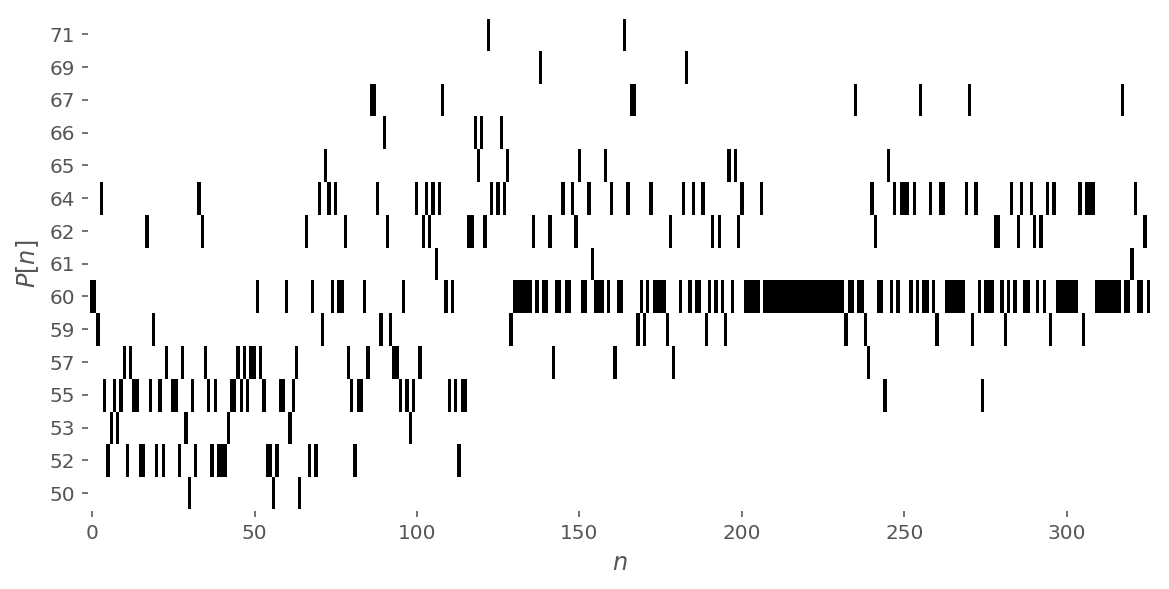

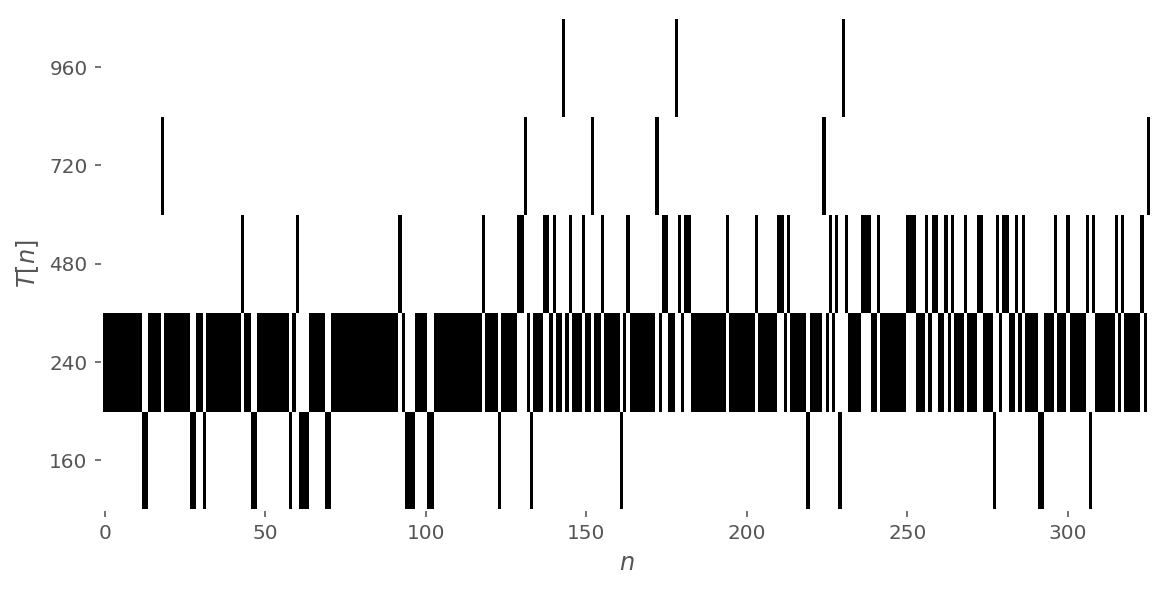

Predicted with Intermediate Output:


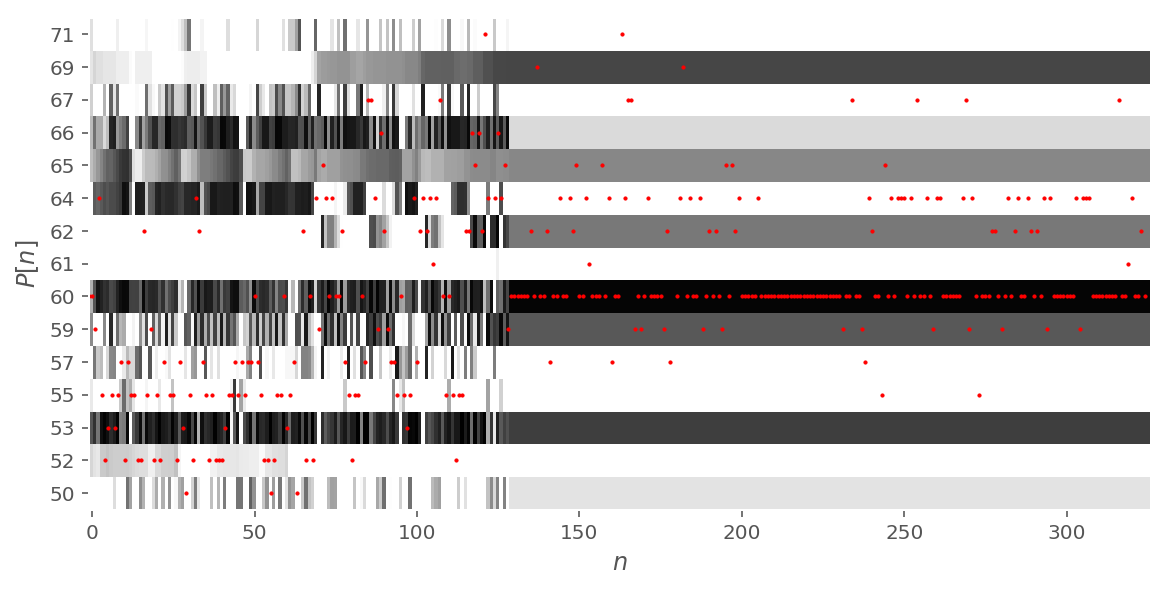

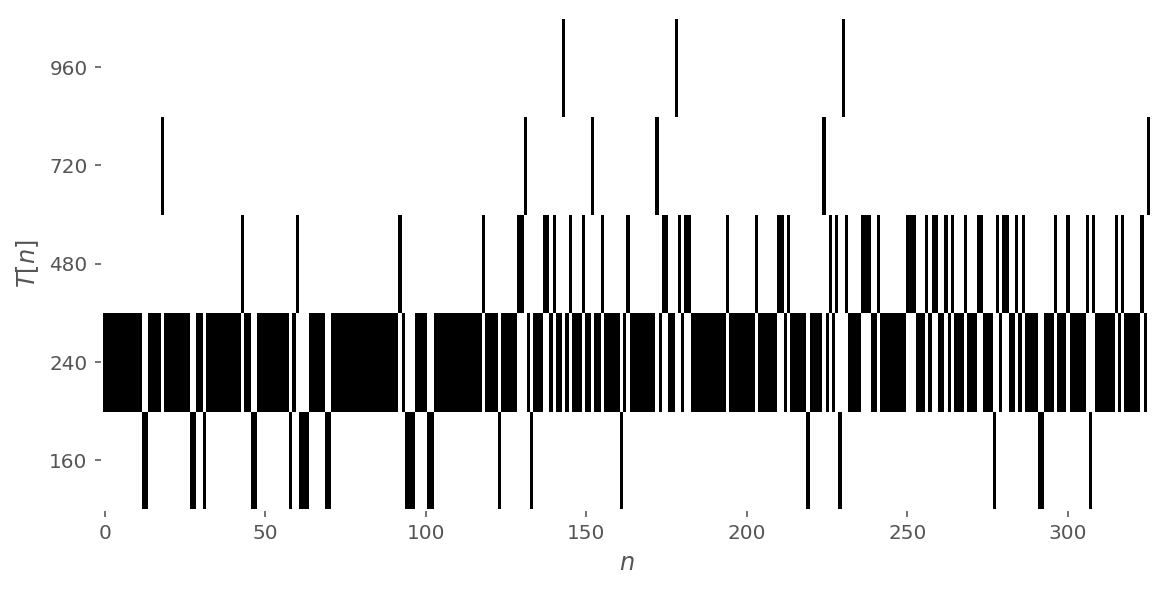

In [113]:
melody_choosen = np.random.choice(list(one_hot_dataset.keys()), 1)
for label in melody_choosen:
    index = -1
    for i, line in zip(range(len(one_hot_dataset)), list(one_hot_dataset.keys())):
        if line==label:
            index = i
    
    data_in = {'XP':np.expand_dims(pitches_dataset[index][:-1], axis=0), 'XT':np.expand_dims(durations_dataset[index][:-1], axis=0)}
    predictions = best_model.predict(data_in)
    t_ , p_ = predictions[0], predictions[1]
    p_ = make_one_hot_econding(np.asarray(p_).squeeze(0))[:len(one_hot_dataset[label]['P'])]
    t_ = make_one_hot_econding(np.asarray(t_).squeeze(0))[:len(one_hot_dataset[label]['T'])]
    
    layer_name = 'HiddenLayer'
    intermediate_layer_model = Model(inputs=best_model.input,
                                     outputs=best_model.get_layer(layer_name).output)
    intermediate_output = intermediate_layer_model.predict(data_in).squeeze(0)
    
    print('Real:')
    plotMelody(one_hot_dataset[label]['P'], one_hot_dataset[label]['T'], dict_for_plot_melody)
    print('Predicted:')
    plotMelody(p_, t_, dict_for_plot_melody)
    print('Predicted with Intermediate Output:')
    plotMelody(p_, t_, dict_for_plot_melody, intermediate_output)

In [82]:
%%time
layer_name = 'HiddenLayer'
intermediate_layer_model_RNN = Model(inputs=RNNmodel.input,
                                 outputs=RNNmodel.get_layer(layer_name).output)
intermediate_output_RNN = intermediate_layer_model_RNN.predict(net_input)
RNN_avg_out = get_avg_out(intermediate_output_RNN)

intermediate_layer_model_GRU = Model(inputs=GRUmodel.input,
                                 outputs=GRUmodel.get_layer(layer_name).output)
intermediate_output_GRU = intermediate_layer_model_GRU.predict(net_input)
GRU_avg_out = get_avg_out(intermediate_output_GRU)

CPU times: user 6min 11s, sys: 5.97 s, total: 6min 17s
Wall time: 5min 28s


ValueError: could not broadcast input array from shape (71) into shape (23)

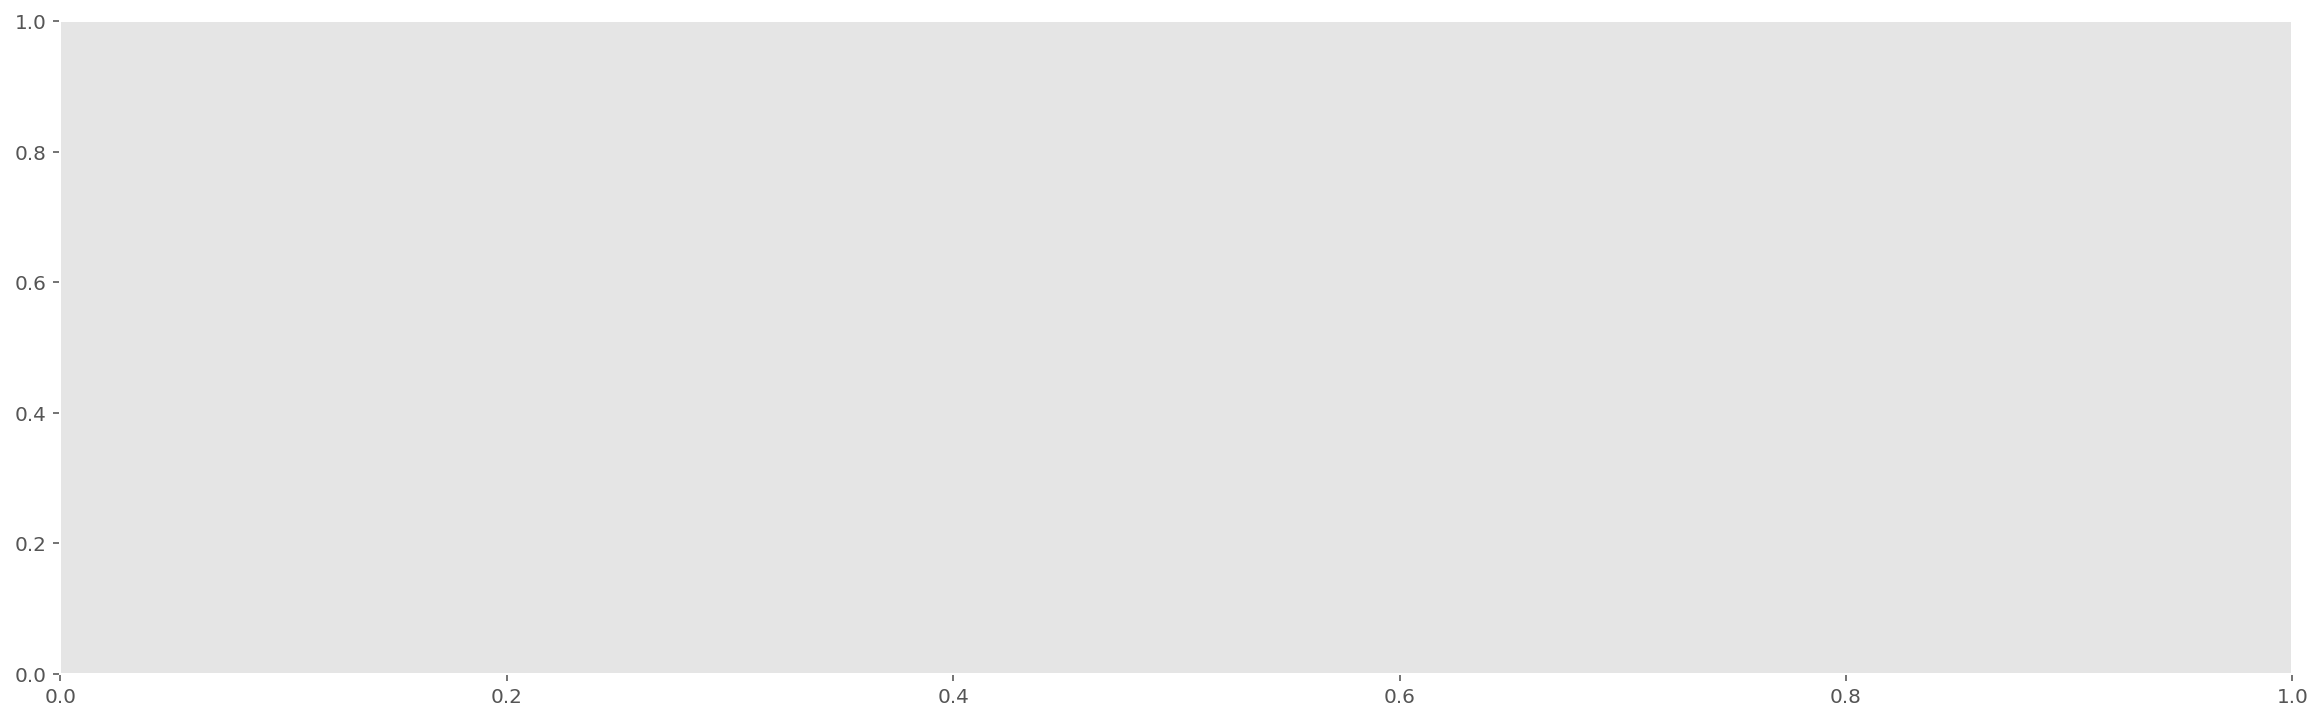

In [83]:
def print_more_histograms(values, names):
    
    fig = plt.figure(figsize = (20,6))
    ax = fig.add_subplot(111)
    x = np.zeros((values[0].shape[0], len(values)))
    for v in range(len(values)):
        x[:,v] = values[v]
        
    bins = values[0].shape[0]
    colors = ['red', 'tan']
    ax.hist(x, bins, normed=1, histtype='bar', color=colors, label=names)
    ax.legend(prop={'size': 10})
    ax.set_ylim([0, 300])
    ax.set_xlabel('avarage value')
    ax.set_ylabel('# occurencies')
    plt.show()
    
    
print_more_histograms([RNN_avg_out, GRU_avg_out], ['RNN Avg Out', 'GRU Avg Out'])

questo grafico rappresenta le medie delle variazioni di tutti i neuroni nell'hidden layer. Sull'asse x ci sono i valori della media e l'istogramma rappresenta il numero di volte che quella media si verifica.
Appena faccio un GRU model serio vedo quali sono le differenze

**Question**: How does the hidden state dynamics explain the performance of the RNN vs GRU models? Explain in term of temporal dependencies and base your explanation on figures obtained in 6.2 and 6.3.
    
**Answer**: 


## Exercise 7: Generation of new melodies
### Description

1. Use your trained best model to generate new melodies. You can do that by starting with a random note, feeding it to your network and sample the output predictions in order to select the next note. Then add this note to your iteratively growing melodies. For your convenience, we provided the `sample` and `writeMIDI` functions. You can use the first in order to perform temperature sampling. The `writeMIDI` function allows you to write a MIDI file from the integer representation.
2. Try different sampling temperatures (e.g. 0.5, 1., 1.5) and observe the effect on your generated melodies.
3. Generate 32 melodies with both the RNN and GRU models
4. Listen to 4 randomly chosen melodies (2 from the GRU model and 2 from the RNN model). To play in a notebook, use a similar approach as the one shown below assuming you have the files `GRU_1.mid` and `RNN_1.mid` at the same level as this notebook. For your own curiosity, you can also directly listen to the MIDI files with your favorite MIDI player but make sure that we can listen to the 4 extracts directly from this notebook (without rerunning it). You might have to use the "Trust notebook" button (in the top right corner) to see the players. This currently only works in jupyter notebook (not jupyter lab). If you have trouble achieving that, upload the MIDI files with your submission.
5. (Optional) If you have a big enough computing power, try adding multiple and bigger layers. You could also try to improve your model with different add-ons, e.g. make your model learn when a melody ends, extend it to other datasets, ...
6. (Optional) If you are happy with your results submit a 1 hour long generated MIDI file to the [AI-generated music challenge](https://www.crowdai.org/challenges/ai-generated-music-challenge). 

### Solution

In [114]:
def extend_one_dim(start):
    return np.expand_dims(start, axis=0)

def from_one_hot_to_integer(list_arr):
    to_ret = []
    for i in range(len(list_arr)):
        to_ret.append(np.argmax(list_arr[i]))
    return to_ret

In [115]:
def generate_music(model, melody_index=None, music_len=500):
    if not melody_index:
        melody_index = np.random.choice(train_input_P.shape[0], 1)

    gen_pitches = []
    gen_durations = []

    p_start, t_start = train_input_P[melody_index], train_input_T[melody_index]
    for i in range(music_len):
        data_in = {'XP':extend_one_dim(p_start), 'XT':extend_one_dim(t_start)}   
        predictions = model.predict(data_in)
        t_ , p_ = predictions[0], predictions[1]
        p_start = make_one_hot_econding(np.asarray(p_).squeeze(0), one_more_line=True)
        t_start = make_one_hot_econding(np.asarray(t_).squeeze(0), one_more_line=False)

        gen_pitches.append(p_start[0])
        gen_durations.append(t_start[0])

    gen_pitches = from_one_hot_to_integer(gen_pitches)
    gen_durations = from_one_hot_to_integer(gen_durations)
    return gen_pitches, gen_durations

In [116]:
melody_index = np.random.randint(len(train_input_P))

In [117]:
print('RNN')
gen_pitches, gen_durations = generate_music(RNNmodel, melody_index=melody_index) # default 25 sec
writeMIDI(gen_pitches, gen_durations, dict_for_plot_melody, 'first_Test.mid')
music21.midi.translate.midiFilePathToStream('first_Test.mid').show('midi')
music21.midi.translate.midiFilePathToStream('chorpus/sessiontune' + str(melody_index) + '.mid').show('midi')

RNN


In [118]:
display('first_Test.mid')
display('chorpus/sessiontune' + str(melody_index) + '.mid')

first_Test.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

0 	 76 	 Note On 	 90
720 	 76 	 Note Off 	 0
720 	 77 	 Note On 	 90
960 	 77 	 Note Off 	 0
960 	 79 	 Note On 	 90
1080 	 79 	 Note Off 	 0
1080 	 67 	 Note On 	 90
1200 	 67 	 Note Off 	 0
1200 	 64 	 Note On 	 90
1320 	 64 	 Note Off 	 0
1320 	 69 	 Note On 	 90
1440 	 69 	 Note Off 	 0
1440 	 65 	 Note On 	 90
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
. 	 . 	 . 	 	 .
104928 	 64 	 Note On 	 90
105168 	 64 	 Note Off 	 0
105168 	 60 	 Note On 	 90
105408 	 60 	 Note Off 	 0
105408 	 62 	 Note On 	 90
105648 	 62 	 Note Off 	 0
105648 	 69 	 Note On 	 90
105888 	 69 	 Note Off 	 0
########################################

chorpus/sessiontune1730.mid
########################################
tick 	 pitch 	 message 	 velocity
########################################

1 	 67 	 Note On 	 105
480 	 67 	 Note Off 	 0
481 	 60 	 Note On 	 80
960 	 60 	 Note Off 	 0
961 

In [119]:
print('GRU')
gen_pitches, gen_durations = generate_music(GRUmodel, melody_index=melody_index) # default 25 sec
writeMIDI(gen_pitches, gen_durations, dict_for_plot_melody, 'first_Test_GRU.mid')
music21.midi.translate.midiFilePathToStream('first_Test_GRU.mid').show('midi')
music21.midi.translate.midiFilePathToStream('chorpus/sessiontune' + str(melody_index) + '.mid').show('midi')

GRU


In [120]:
print('LSTM')
gen_pitches, gen_durations = generate_music(LSTMmodel, melody_index=melody_index) # default 25 sec
writeMIDI(gen_pitches, gen_durations, dict_for_plot_melody, 'first_Test_LSTM.mid')
music21.midi.translate.midiFilePathToStream('first_Test_LSTM.mid').show('midi')
music21.midi.translate.midiFilePathToStream('chorpus/sessiontune' + str(melody_index) + '.mid').show('midi')

LSTM


**Question**: What is the effect of the sampling temperature on the generated melodies?
    
**Answer**: 

**Question**: Are the generated melodies from the RNN model different from the one generated by the GRU model? If yes, what are the main differences?

**Answer**: 

